In [82]:
import sys
sys.path.append('/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway
from matplotlib.backends.backend_pdf import PdfPages
import re
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [110]:
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])
deck_table["rank"] = pd.to_numeric(deck_table["rank"])

In [111]:
deck_table.tail(25)

deckId  eventId  pilotId                 deckUrl  \
3205    3206      611     1270  ?e=29252&d=430230&f=ST   
3206    3207      611     1669  ?e=29252&d=430227&f=ST   
3207    3208      611     1827  ?e=29252&d=430229&f=ST   
3208    3209      612     1908  ?e=29258&d=430263&f=ST   
3209    3210      612      475  ?e=29258&d=430264&f=ST   
3210    3211      612     1909  ?e=29258&d=430265&f=ST   
3211    3212      612      245  ?e=29258&d=430266&f=ST   
3212    3213      612     1910  ?e=29258&d=430269&f=ST   
3213    3214      612     1911  ?e=29258&d=430267&f=ST   
3214    3215      612       84  ?e=29258&d=430270&f=ST   
3215    3216      612     1699  ?e=29258&d=430268&f=ST   
3216    3217      613     1912  ?e=29265&d=430299&f=ST   
3217    3218      613      547  ?e=29265&d=430300&f=ST   
3218    3219      613     1913  ?e=29265&d=430302&f=ST   
3219    3220      613     1914  ?e=29265&d=430301&f=ST   
3220    3221      614     1915  ?e=29257&d=430247&f=ST   
3221    3222      614     1916  ?e=29257&d=430248&f=ST   
3222    3223      614     1917  ?e=29257&d=430249&f=ST   
3223    3224      614     1918  ?e=29257&d=430250&f=ST   
3224    3225      614     1434  ?e=29257&d=430251&f=ST   
3225    3226      614     1919  ?e=29257&d=430252&f=ST   
3226    3227      614     1920  ?e=29257&d=430253&f=ST   
3227    3228      614     1921  ?e=29257&d=430254&f=ST   
3228    3229      615     1922  ?e=29266&d=430303&f=ST   
3229    3230      615     1923  ?e=29266&d=430304&f=ST   

                         name  rank archetype    category  
3205             Dimir Rogues     5     rogue       dimir  
3206               Naya Aggro     5     aggro        naya  
3207               Naya Aggro     5     aggro        naya  
3208              Gruul Aggro     1     aggro       gruul  
3209            Red Deck Wins     2     aggro    mono red  
3210            Red Deck Wins     3     aggro    mono red  
3211            Red Deck Wins     3     aggro    mono red  
3212        Esper DOOM Yorion     5   control       esper  
3213            Red Deck Wins     5     aggro    mono red  
3214            Red Deck Wins     5     aggro    mono red  
3215             Weenie White     5     aggro  mono white  
3216            Azorius Aggro     1     aggro     azorius  
3217           Selesnya Aggro     2     aggro    selesnya  
3218             Abzan Yorion     3   control       abzan  
3219          Sultai Midrange     3  midrange      sultai  
3220            Weenie White      1     aggro  mono white  
3221      Boros Cycling Aggro     2   cycling       boros  
3222      Boros Cycling Aggro     3   cycling       boros  
3223      Boros Cycling Aggro     4   cycling       boros  
3224             Weenie White     5     aggro  mono white  
3225  Sultai Yorion Ultimatum     6      ramp      sultai  
3226              Gruul Aggro     7     aggro       gruul  
3227             Weenie White     8     aggro  mono white  
3228              Boros Aggro     1     aggro       boros  
3229            Izzet Control     2   control       izzet

In [112]:
event_table.tail(25)

eventId                                                  name  \
590      591      SCG Tour Online - Satellite #2 @ Star City Games   
591      592                    FNM at Home @ Draagoons Hobby Shop   
592      593                                   FNM @ Lotus eSports   
593      594                               Event @ On Curve Events   
594      595                              Championship @ Masonetis   
595      596      SCG Tour Online - Satellite #5 @ Star City Games   
596      597      SCG Tour Online - Satellite #6 @ Star City Games   
597      598             Japan Championship 2020 Final @ BIG Magic   
598      599      United Valentine Invitational @ F2K (Fade2Karma)   
599      600                                   Grinch Melee @ MTGA   
600      601                   IV Card Games Championship @ Brasil   
601      602      SCG Tour Online - Satellite #8 @ Star City Games   
602      603                        Chill Out 2 @ MTG: La Gedencia   
603      604                             Event @ The Monkey Planet   
604      605  5K Kaldheim Championship Qualifier @ Star City Games   
605      606                   Reach Out In Love @ Insight eSports   
606      607                MAJH Sunday Series @ Malchijah Harding   
607      608                               Event @ On Curve Events   
608      609                     Weekly Event @ The Mythic Society   
609      610                  Ligue Février #3 @ Torino Tournament   
610      611                 Event @ Taverna Geek (Santos, Brasil)   
611      612                                 Event @ Lotus eSports   
612      613                    Gentry ! @ The Gentry Magic League   
613      614                               MTGO Standard Challenge   
614      615                                   Grinch Melee @ MTGA   

                                           link       date latest_set  
590  https://www.mtgtop8.com/event?e=29180&f=ST 2021-02-12   Kaldheim  
591  https://www.mtgtop8.com/event?e=29183&f=ST 2021-02-12   Kaldheim  
592  https://www.mtgtop8.com/event?e=29191&f=ST 2021-02-12   Kaldheim  
593  https://www.mtgtop8.com/event?e=29192&f=ST 2021-02-12   Kaldheim  
594  https://www.mtgtop8.com/event?e=29203&f=ST 2021-02-13   Kaldheim  
595  https://www.mtgtop8.com/event?e=29204&f=ST 2021-02-13   Kaldheim  
596  https://www.mtgtop8.com/event?e=29205&f=ST 2021-02-13   Kaldheim  
597  https://www.mtgtop8.com/event?e=29206&f=ST 2021-02-13   Kaldheim  
598  https://www.mtgtop8.com/event?e=29207&f=ST 2021-02-13   Kaldheim  
599  https://www.mtgtop8.com/event?e=29214&f=ST 2021-02-14   Kaldheim  
600  https://www.mtgtop8.com/event?e=29215&f=ST 2021-02-14   Kaldheim  
601  https://www.mtgtop8.com/event?e=29217&f=ST 2021-02-14   Kaldheim  
602  https://www.mtgtop8.com/event?e=29218&f=ST 2021-02-14   Kaldheim  
603  https://www.mtgtop8.com/event?e=29236&f=ST 2021-02-15   Kaldheim  
604  https://www.mtgtop8.com/event?e=29235&f=ST 2021-02-14   Kaldheim  
605  https://www.mtgtop8.com/event?e=29237&f=ST 2021-02-14   Kaldheim  
606  https://www.mtgtop8.com/event?e=29238&f=ST 2021-02-14   Kaldheim  
607  https://www.mtgtop8.com/event?e=29240&f=ST 2021-02-16   Kaldheim  
608  https://www.mtgtop8.com/event?e=29241&f=ST 2021-02-16   Kaldheim  
609  https://www.mtgtop8.com/event?e=29242&f=ST 2021-02-15   Kaldheim  
610  https://www.mtgtop8.com/event?e=29252&f=ST 2021-02-16   Kaldheim  
611  https://www.mtgtop8.com/event?e=29258&f=ST 2021-02-16   Kaldheim  
612  https://www.mtgtop8.com/event?e=29265&f=ST 2021-02-16   Kaldheim  
613  https://www.mtgtop8.com/event?e=29257&f=ST 2021-02-15   Kaldheim  
614  https://www.mtgtop8.com/event?e=29266&f=ST 2021-02-17   Kaldheim

In [113]:
LANDS = ["Island", "Mountain", "Forest", "Plains", "Swamp"]
def get_illegal_decks():
    return full_table[
        ~full_table["cardId"].isin(
            card_table[card_table["standardLegality"] == "legal"]["cardId"]
        )
    ]["deckId"]

def get_first_place_decks():
    illegal_decks = get_illegal_decks()
    return deck_table[
        (deck_table["rank"]==1)
        & (~deck_table["deckId"].isin(illegal_decks))
    ].copy()

def get_main_decks():
    illegal_decks = get_illegal_decksdecks()
    return full_table[
        (~full_table["name"].isin(LANDS))
        & (~full_table["deckId"].isin(illegal_decks))
        & (full_table["slot"] == "md")
    ].copy()

In [114]:
# Common Slices
illegal_decks = full_table[
    ~full_table["cardId"].isin(card_table[card_table["standardLegality"] == "legal"]["cardId"])
]["deckId"]

first_place_decks = deck_table[
    (deck_table["rank"] == 1)
    & ~(deck_table["deckId"].isin(illegal_decks))
].copy()
main_decks = full_table[
    (~full_table["name"].isin(["Island", "Mountain", "Forest", "Plains", "Swamp"]))
    & (full_table["slot"] == "md")
    & ~(full_table["deckId"].isin(illegal_decks))
].copy()


In [115]:
def get_most_used_cards(df):
    grouped_table = (
        df
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

In [116]:
most_used_cards = get_most_used_cards(main_decks)

In [117]:
main_decks.drop_duplicates(subset=["deckId"])["name_deck"].value_counts()

Gruul Aggro                  539
Mono Green Aggro             226
Dimir Mill                   204
Red Deck Wins                167
Esper DOOM Yorion            164
Rakdos Aggro                 156
Dimir Control                110
Dimir Rogue                   87
Temur Ramp Ultimatum          79
UB Control                    62
Gruul Adventure Aggro         54
Selesnya Aggro                52
Boros Cycling Aggro           50
Izzet Control                 48
Golgari Aggro                 47
Temur Ultimatum               41
Naya Aggro                    40
Sultai Yorion Ultimatum       38
Weenie White                  38
UW Control                    34
Jund                          29
UB Mill                       26
Rakdos Control                26
Grixis Control                26
Dimir Aggro                   23
Mono Black Aggro              20
Temur Ramp Ultimatum \t       19
Boros Aggro                   16
Sultai Yorion                 16
Mono Red Control              14
Sultai Con

In [105]:
def most_winning_archetypes(show=False):
#     first_place_decks.loc[first_place_decks["archetype"] == "rogue", "archetype"] = "mill"
    grouped_archetypes = first_place_decks.groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
#     sns.barplot(data=grouped_archetypes, x="archetype", y="rank")
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30)
    plt.title("Most Winning Archetypes")
    if show:
        plt.show()

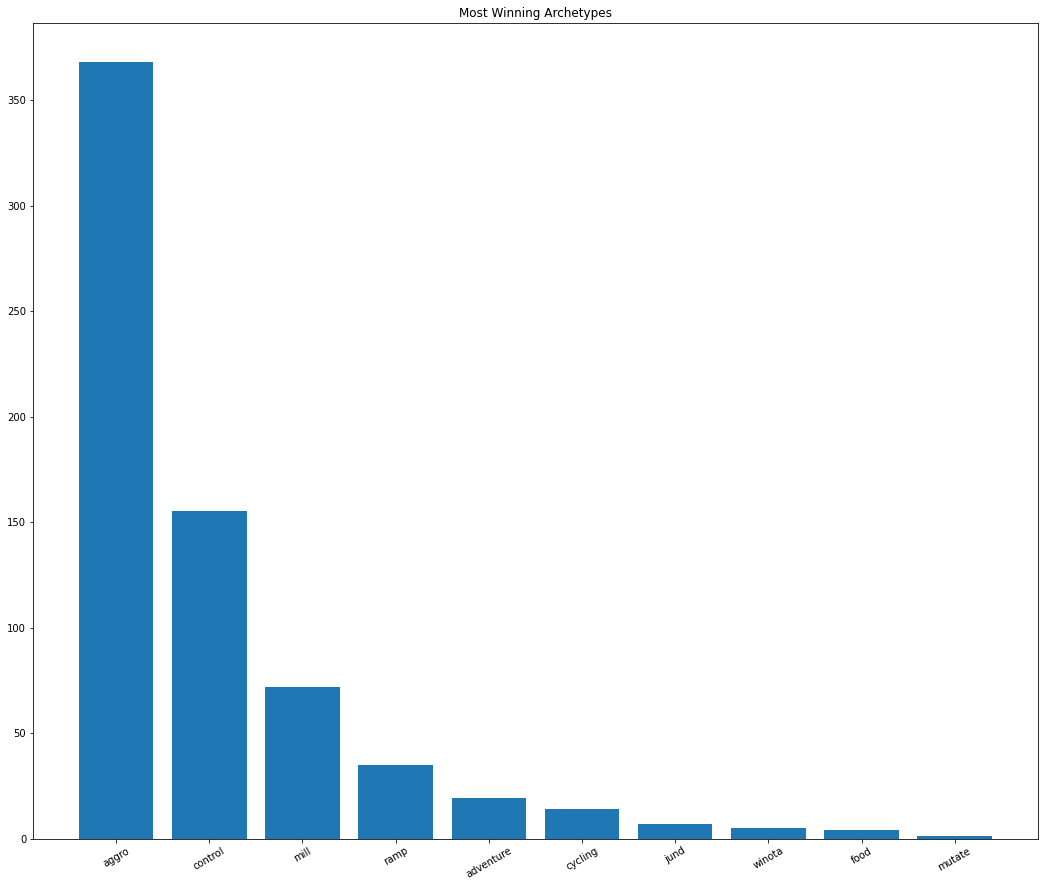

In [106]:
most_winning_archetypes()

In [ ]:
def most_winning_archetypes_last_2_months(df, show=False):
    last_2_months = df[df["event_date"]]

In [107]:
def most_winning_colors(df, show=False):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30)
    if show:
        plt.show()

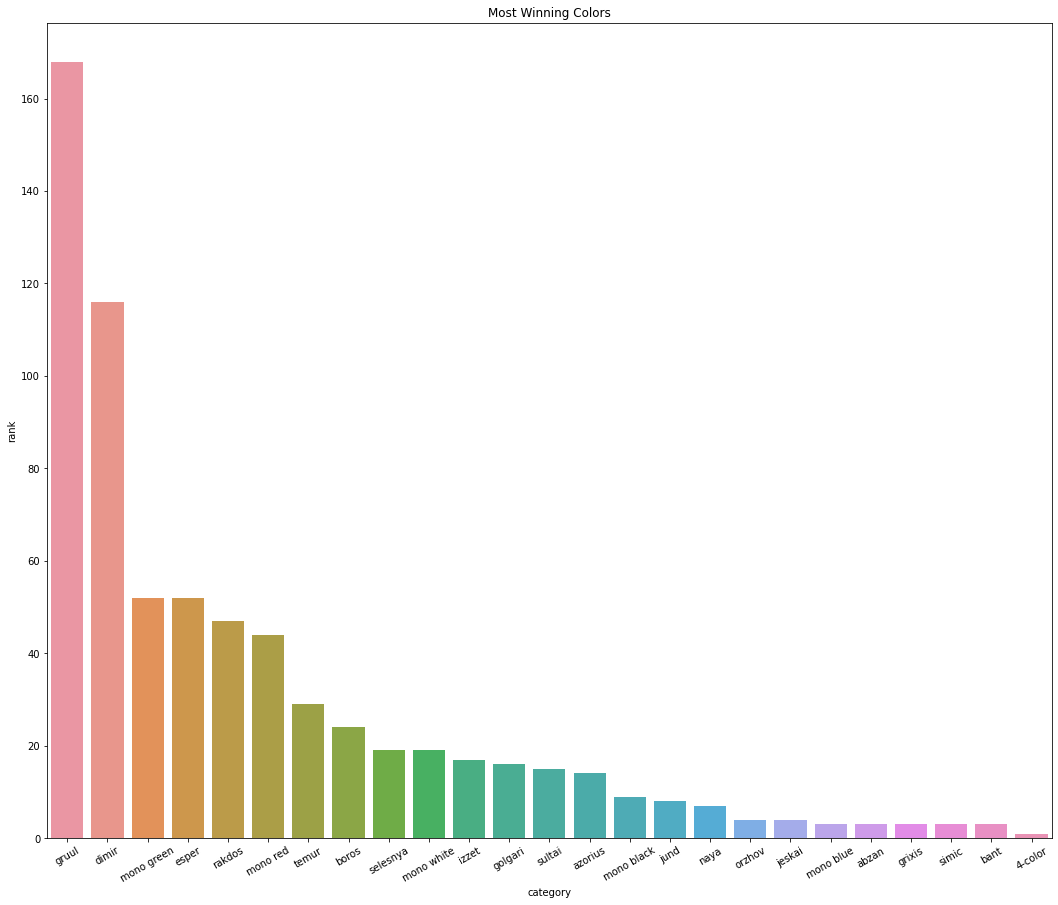

In [108]:
most_winning_colors(first_place_decks)

In [94]:
def most_winning_colors_by_set(df, show=False):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["category", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.xlabel("")
    plt.ylabel("Number of Decks")
    plt.xticks(rotation=45)
    if show:
        plt.show()

# most_winning_colors_by_set(first_place_decks, show=True)

In [95]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

(0.0,
 1.0,
 category   gruul  mono green
 archetype                   
 aggro        549         258,
 array([[549., 258.]]))

In [96]:
def colors_and_archetypes(df, archetype, show=False):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Decks")
    if show:
        plt.show()

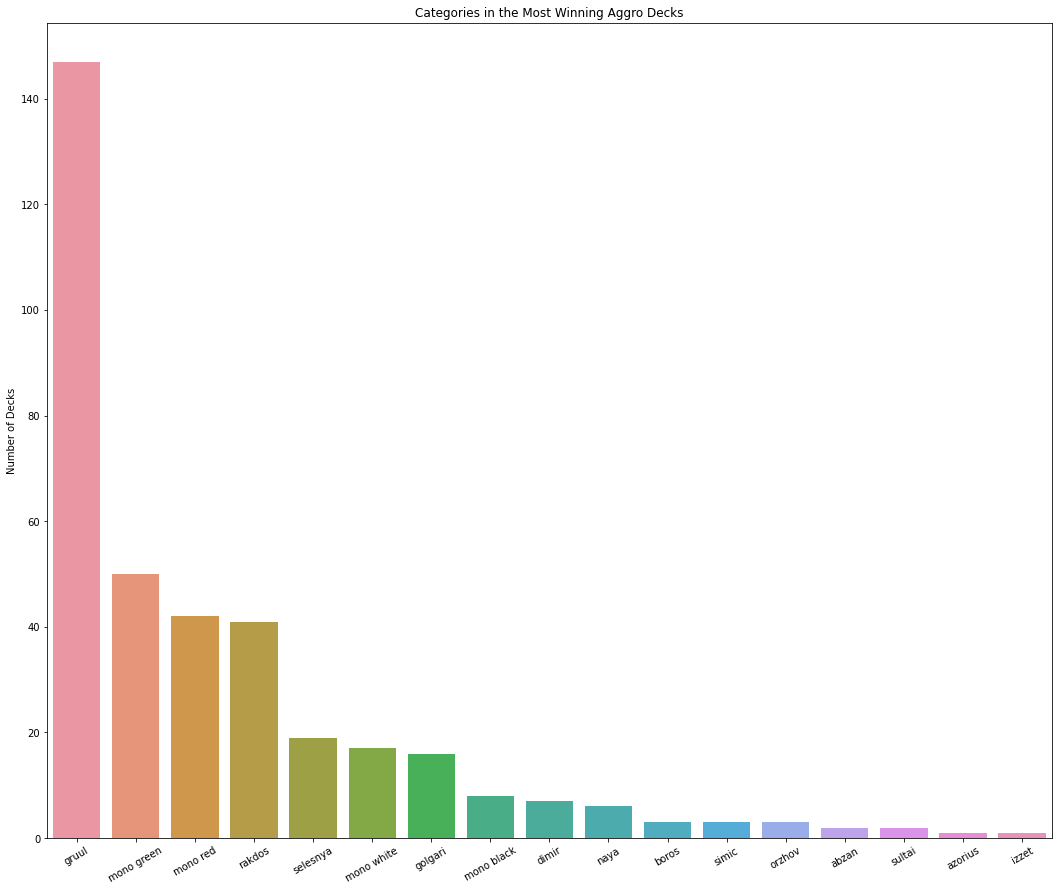

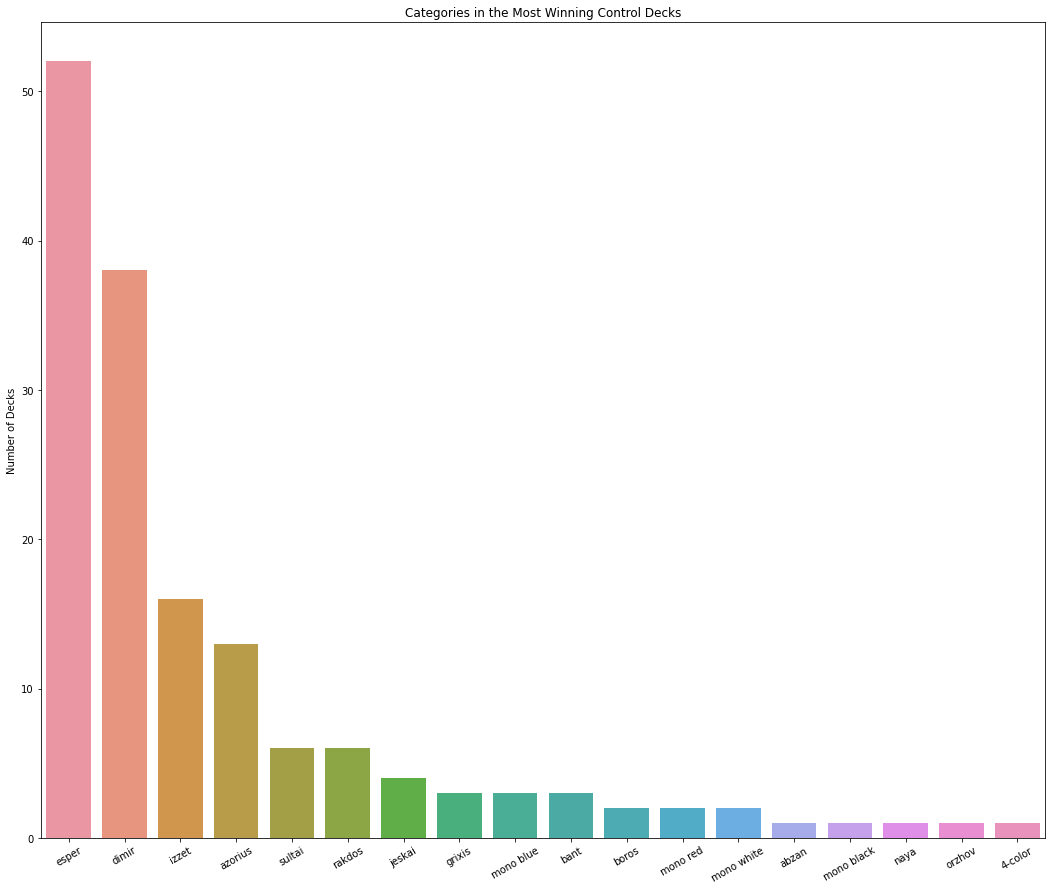

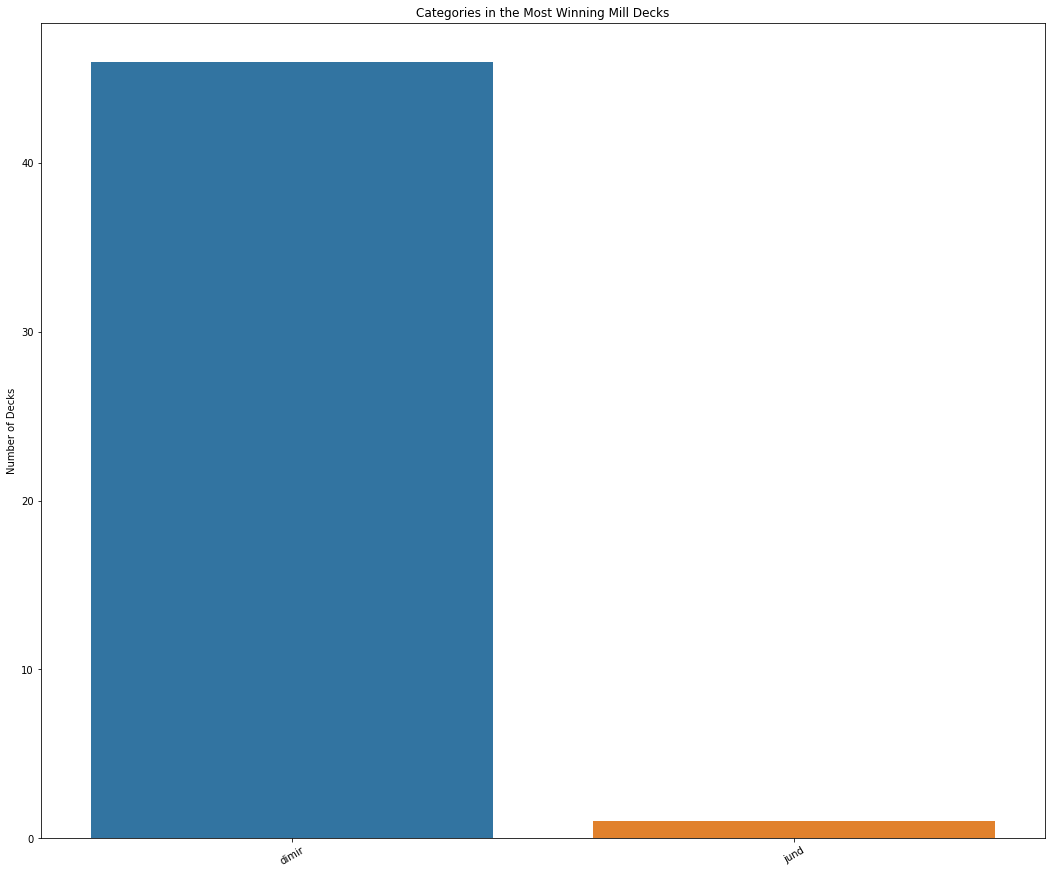

In [97]:
def topn_colors_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n].tolist()
    for archetype in topn_archetypes:
        colors_and_archetypes(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_colors_archetypes(first_place_decks, show=True, n=3)

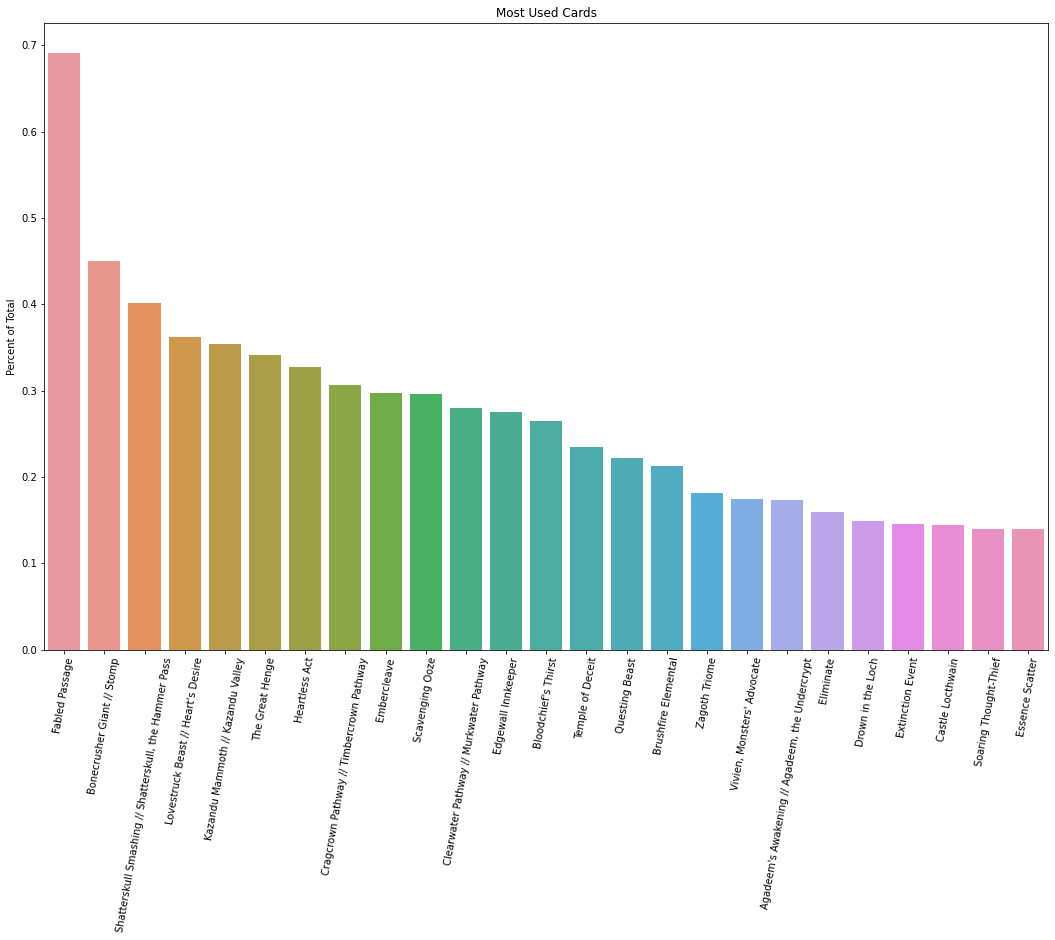

In [98]:
def most_used_cards_graphics(df, show=False):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.title("Most Used Cards")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.xlabel("")
    plt.ylabel("Percent of Total")
    if show:
        plt.show()
    
most_used_cards_graphics(main_decks, show=True)

In [99]:
def most_used_cards_in_archetype(df, archetype, show=False):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    if show:
        plt.show()

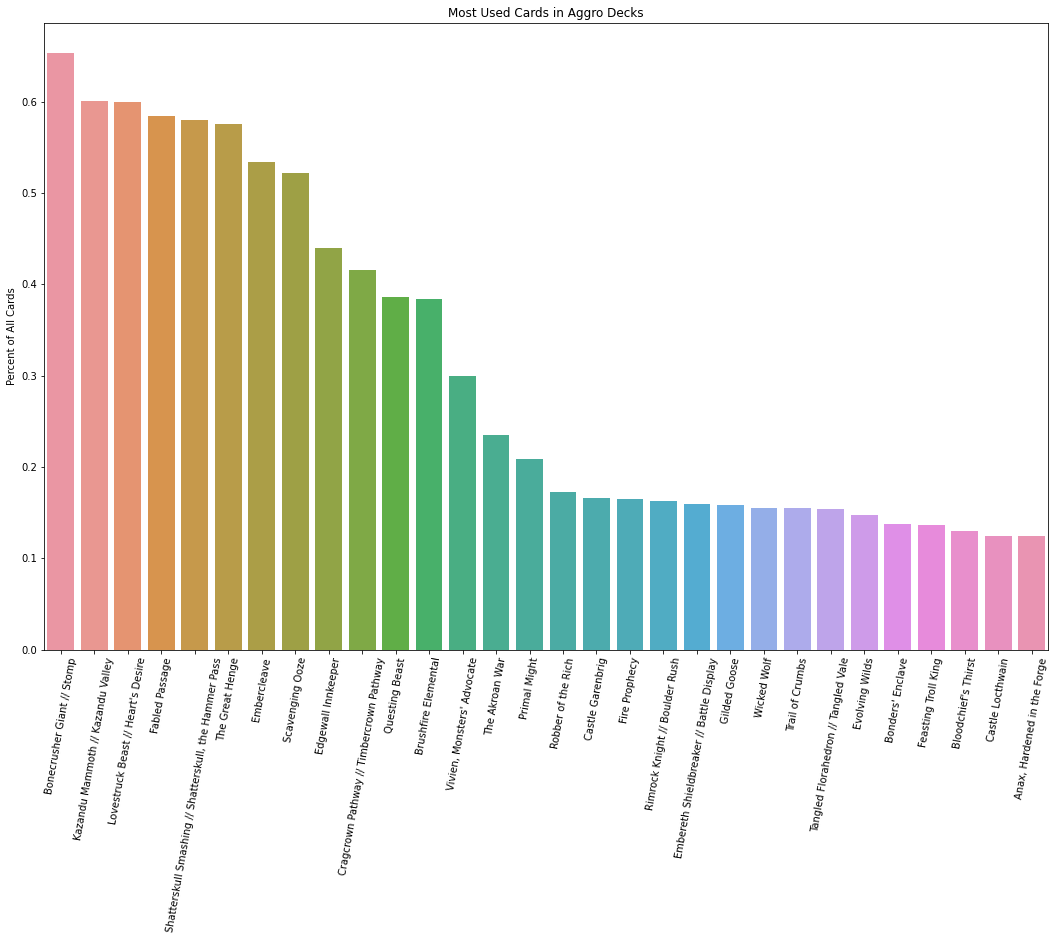

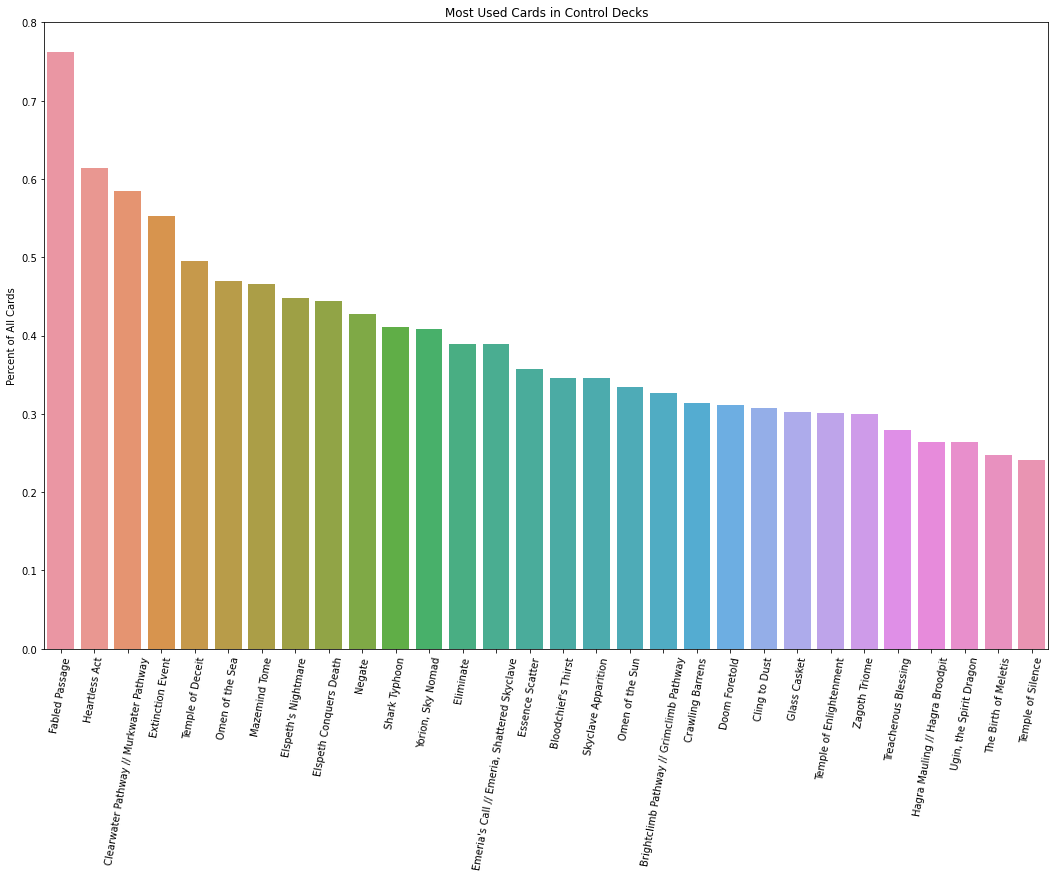

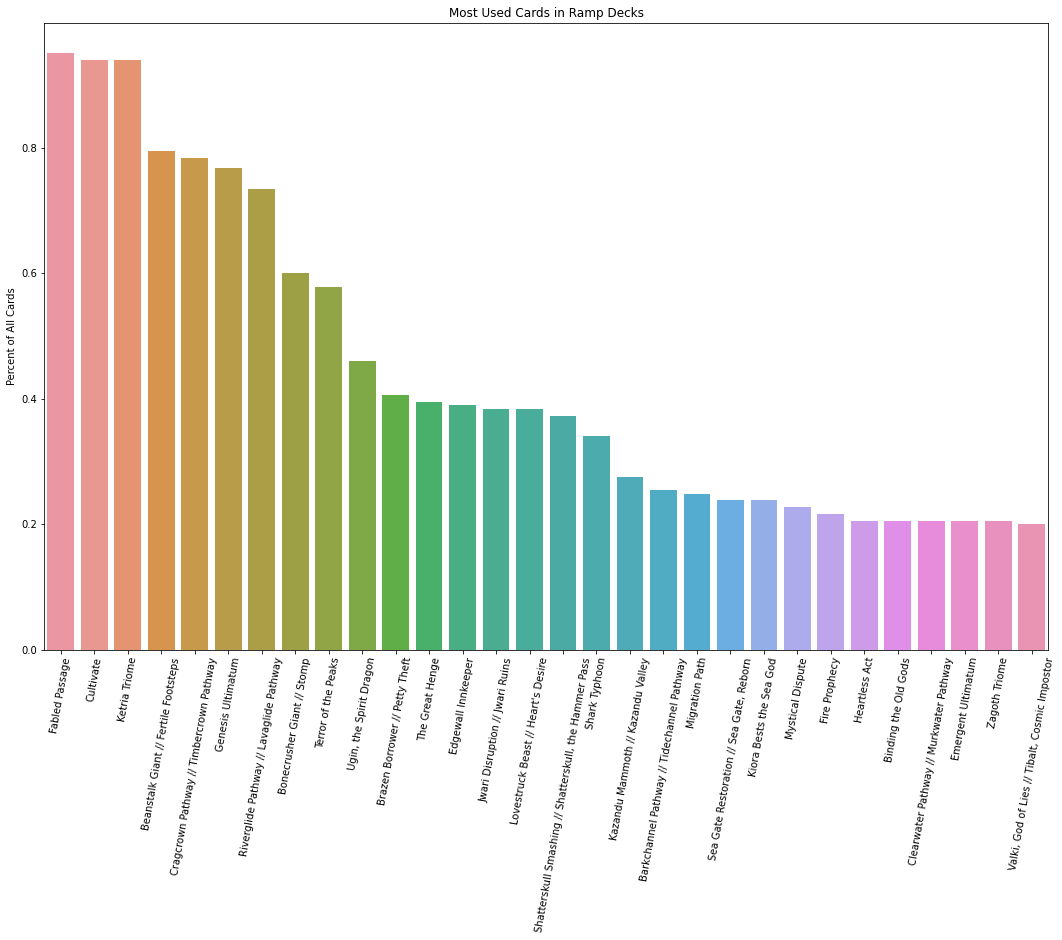

In [100]:
def topn_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = deck_table["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        most_used_cards_in_archetype(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_archetypes(main_decks, n=3, show=True)

In [101]:
def most_used_cards_in_category(df, category, show=False):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Decks")
    plt.xlabel("")
    plt.xticks(rotation=80)
    if show:
        plt.show()

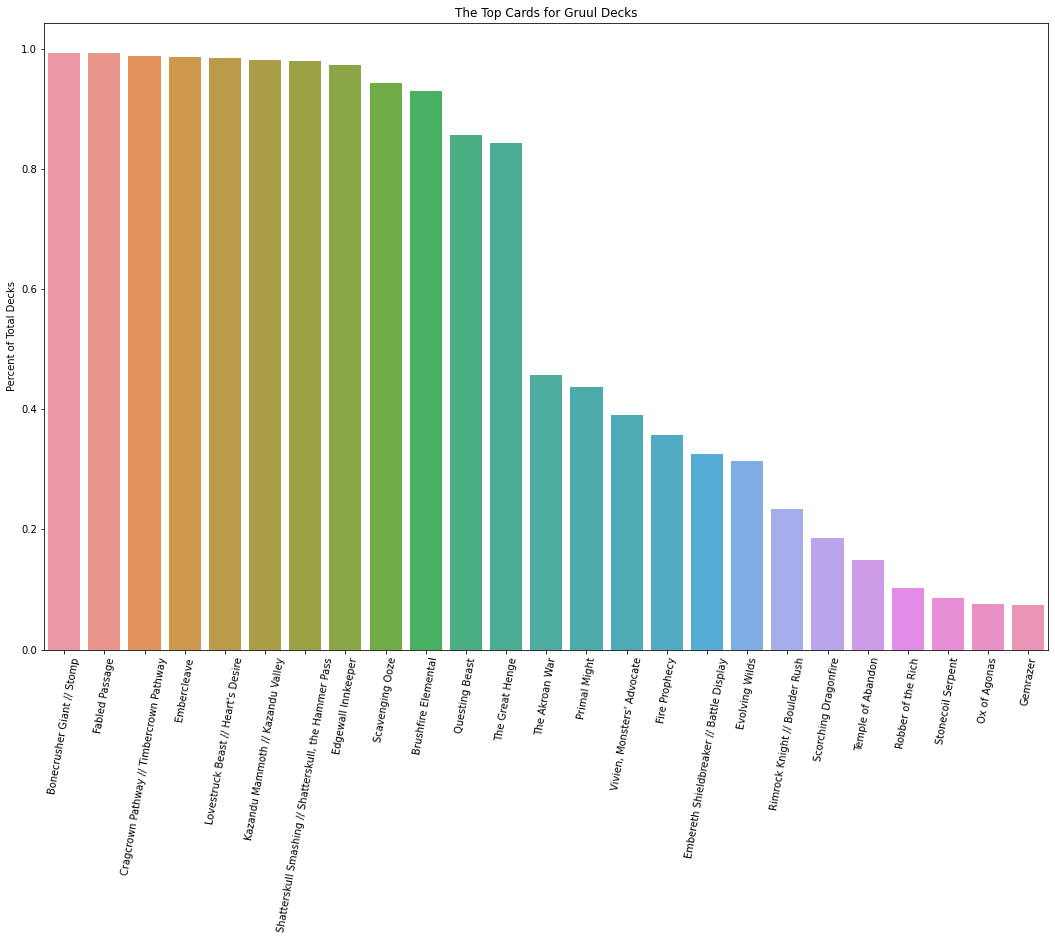

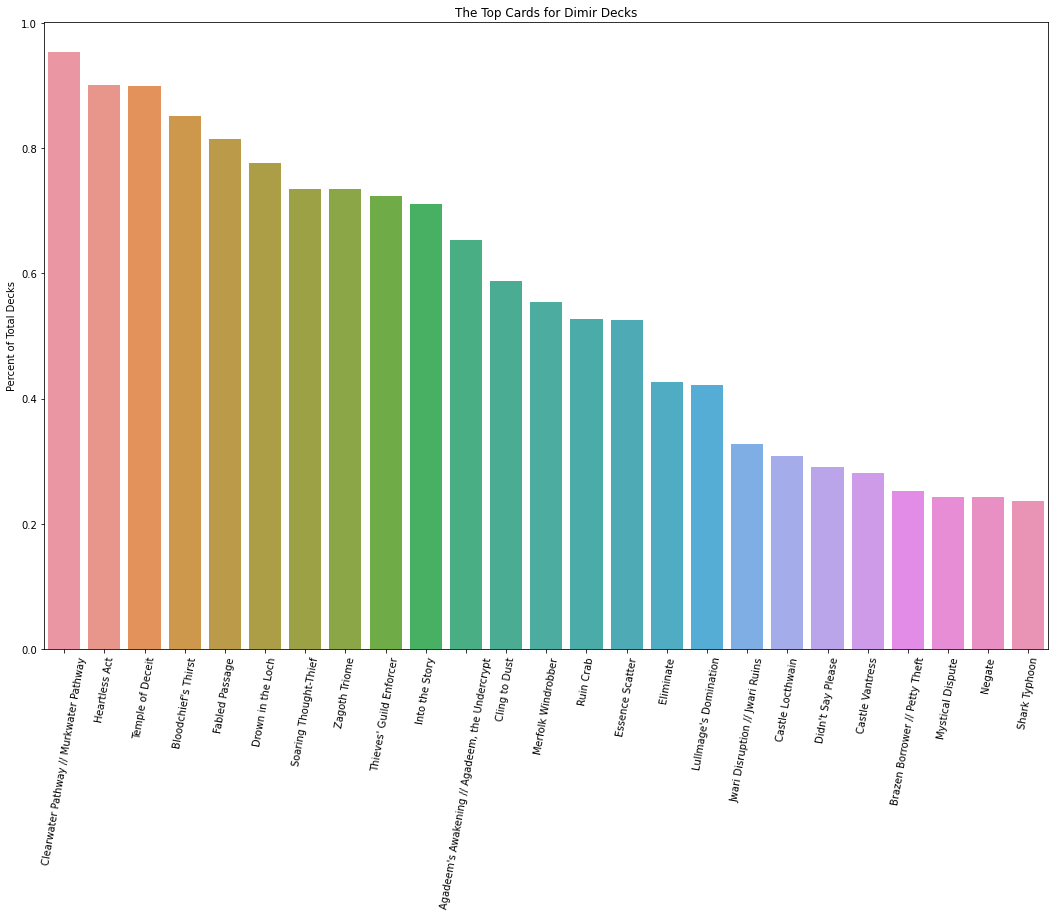

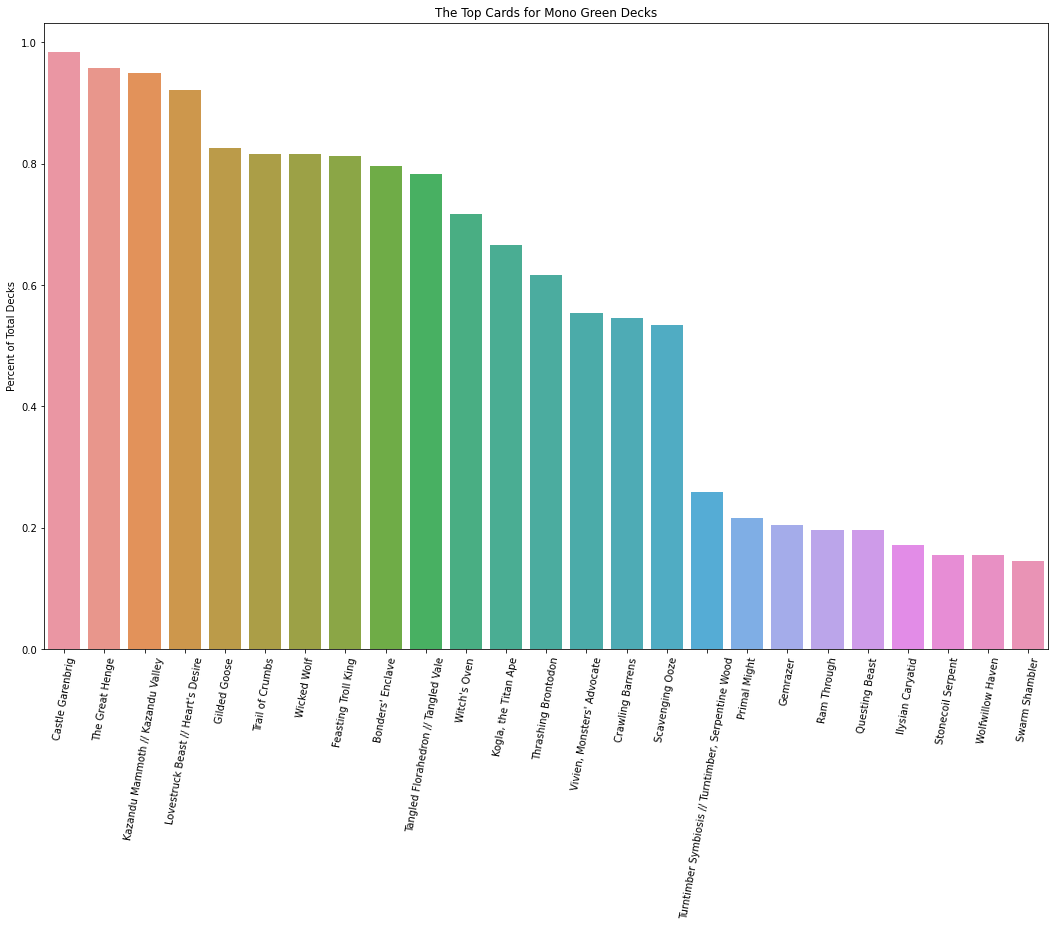

In [102]:
def topn_categories(df, n=10, show=False, pdf=None):
    topn_categories = deck_table["category"].value_counts().index[:n]
    for category in topn_categories:
        most_used_cards_in_category(df, category, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_categories(main_decks, n=3, show=True)

In [103]:
def cards_by_set(df, unique_cards=False, show=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    title = "Cards"
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
        title="Unique Cards"
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    plt.figure(figsize=(18, 15))
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.title(f"{title} Used Per Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()
    

In [23]:
first_place_decks

deckId  eventId  pilotId                            deckUrl  \
0          1        1        3             ?e=27938&d=421597&f=ST   
2          3        2        5             ?e=27939&d=421599&f=ST   
3          4        3        6             ?e=27940&d=421600&f=ST   
4          5        4        7             ?e=27925&d=421512&f=ST   
12        13        5       15             ?e=27918&d=421478&f=ST   
16        17        6       19             ?e=27921&d=421484&f=ST   
24        25        7       26             ?e=27886&d=421193&f=ST   
26        27        8       28             ?e=27898&d=421353&f=ST   
30        31        9       32             ?e=27901&d=421373&f=ST   
38        39       10       39             ?e=27902&d=421381&f=ST   
42        43       11       43             ?e=27919&d=421482&f=ST   
43        44       12       44             ?e=27920&d=421483&f=ST   
44        45       13       45             ?e=27941&d=421601&f=ST   
46        47       14       47             ?e=27876&d=421119&f=ST   
54        55       15       54             ?e=27885&d=421189&f=ST   
58        59       16       57             ?e=27888&d=421199&f=ST   
66        67       17       65             ?e=27905&d=421389&f=ST   
74        75       18       73             ?e=27860&d=421013&f=ST   
82        83       19       81             ?e=27863&d=421032&f=ST   
85        86       20       84             ?e=27877&d=421127&f=ST   
93        94       21       91             ?e=27878&d=421135&f=ST   
101      102       22       99  ?e=27894&d=421299&f=ST&show_pts=Y   
121      122       23      119             ?e=27900&d=421365&f=ST   
129      130       24      127             ?e=27842&d=420939&f=ST   
137      138       25      135             ?e=27847&d=420959&f=ST   
139      140       26      137             ?e=27855&d=420991&f=ST   
141      142       27      138             ?e=27857&d=420995&f=ST   
143      144       28      140             ?e=27859&d=421005&f=ST   
151      152       29      148             ?e=27889&d=421207&f=ST   
155      156       30      152  ?e=27893&d=421249&f=ST&show_pts=Y   
156      157       30      153  ?e=27893&d=421288&f=ST&show_pts=Y   
186      187       31      183             ?e=27834&d=420857&f=ST   
194      195       32       85             ?e=27840&d=420915&f=ST   
202      203       33      198             ?e=27843&d=420947&f=ST   
204      205       34      200             ?e=27845&d=420953&f=ST   
206      207       35       18             ?e=27846&d=420955&f=ST   
210      211       36      204             ?e=27848&d=420961&f=ST   
211      212       37      205             ?e=27853&d=420981&f=ST   
219      220       38      213             ?e=27811&d=420676&f=ST   
227      228       39      221             ?e=27822&d=420766&f=ST   
235      236       40      229             ?e=27823&d=420782&f=ST   
243      244       41      237             ?e=27828&d=420820&f=ST   
244      245       42      238             ?e=27839&d=420907&f=ST   
252      253       43      245             ?e=27814&d=420710&f=ST   
254      255       44      247             ?e=27786&d=420536&f=ST   
262      263       45      254             ?e=27787&d=420544&f=ST   
270      271       46       15             ?e=27788&d=420552&f=ST   
278      279       47      268             ?e=27792&d=420580&f=ST   
280      281       48      270             ?e=27805&d=420643&f=ST   
282      283       49       40             ?e=27808&d=420660&f=ST   
286      287       50       84             ?e=27778&d=420464&f=ST   
294      295       51      280             ?e=27785&d=420520&f=ST   
302      303       52      287             ?e=27791&d=420572&f=ST   
310      311       53      295             ?e=27801&d=420633&f=ST   
312      313       54      297             ?e=27802&d=420635&f=ST   
314      315       55       18             ?e=27803&d=420637&f=ST   
318      319       56      301             ?e=27807&d=420659&f=ST   
319 

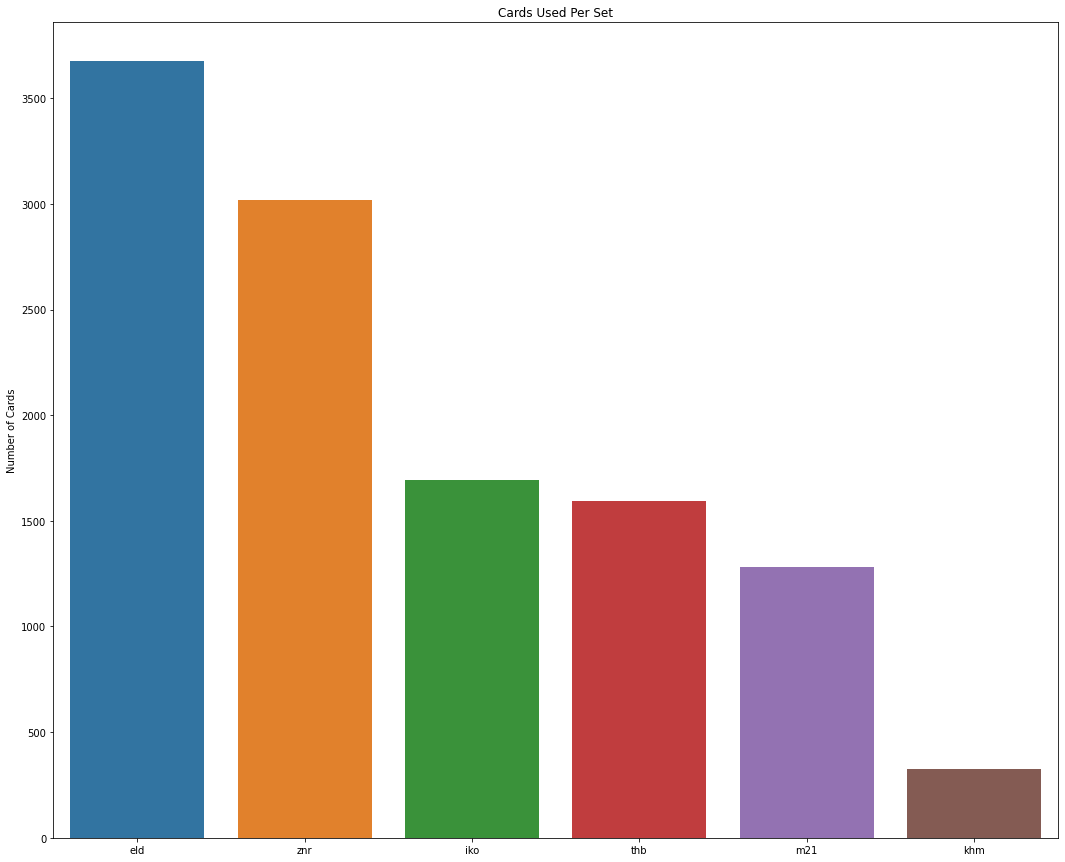

In [24]:
cards_by_set(main_decks,show=True)

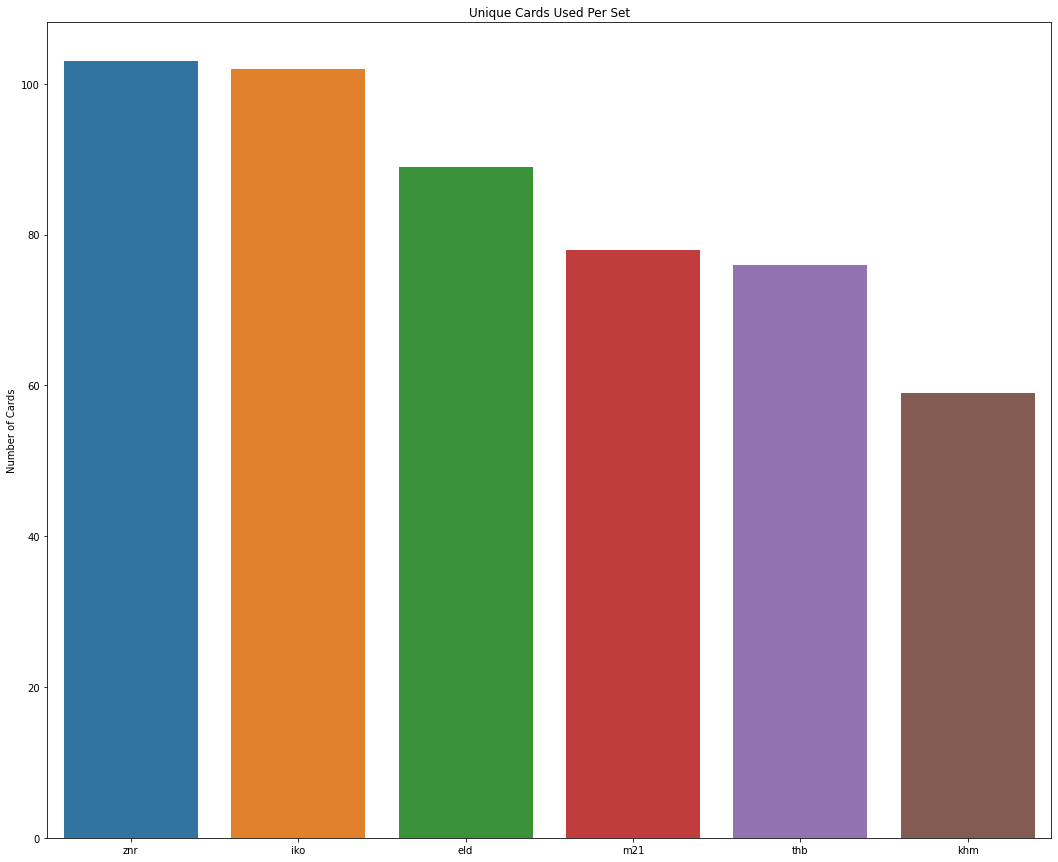

In [25]:
cards_by_set(main_decks,unique_cards=True, show=True)

In [26]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

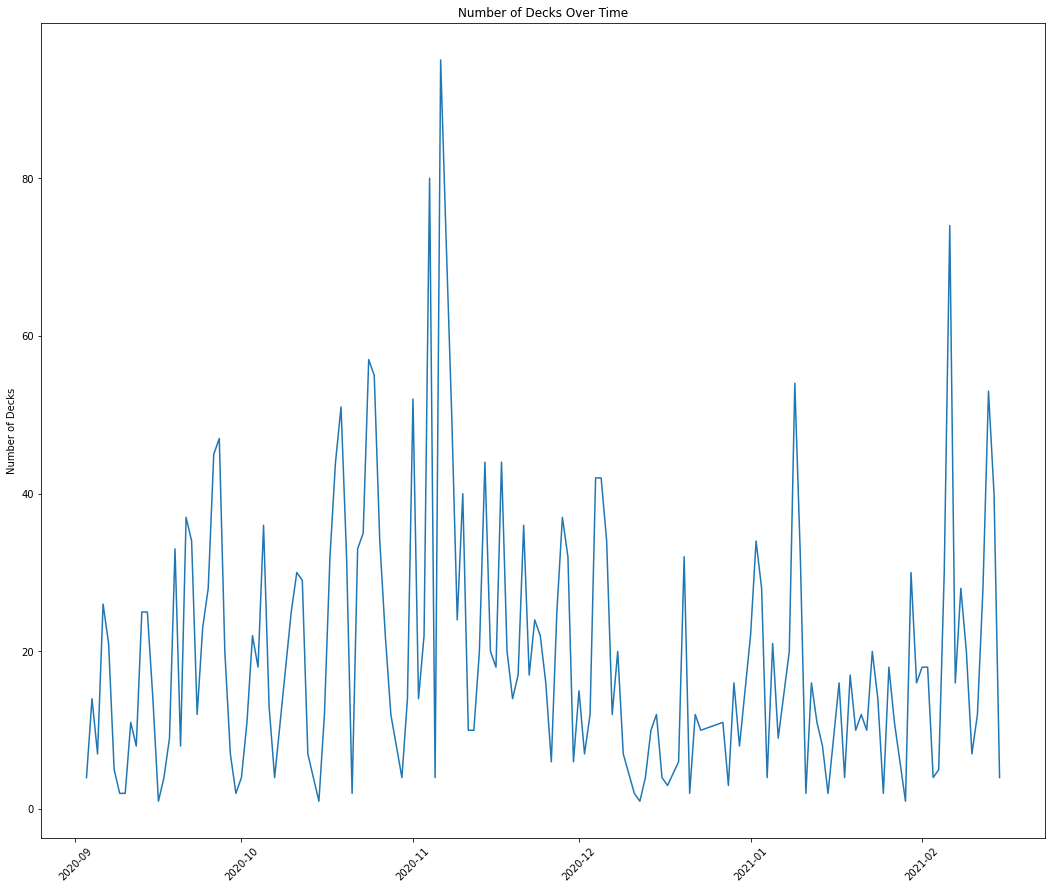

In [27]:
def number_of_decks_over_time(df, show=False):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(18, 15))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks Over Time")
    if show:
        plt.show()
    
    
number_of_decks_over_time(full_table, show=True)

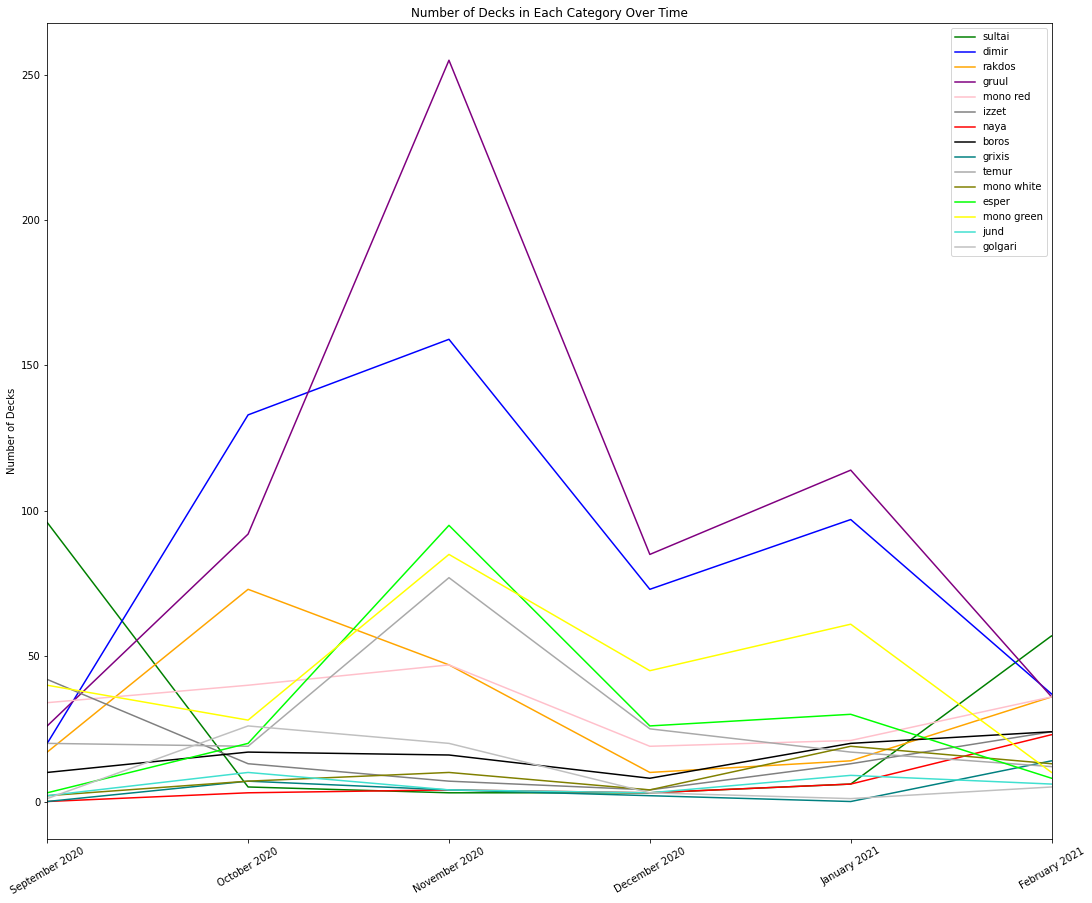

In [28]:
def categories_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_categories = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["category"].value_counts().index[:15]
    colors = ["green", "blue", "orange", "purple", "pink",
              "grey", "red", "black", "teal", "darkgrey",
              "olive", "lime", "yellow", "turquoise", "silver"
             ]
    plt.figure(figsize=(18, 15))
    for cat, color in zip(top_categories, colors):
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat, color=color)
    
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks in Each Category Over Time")
    plt.legend()
    if show:
        plt.show()
    
categories_over_time(full_table, show=True)

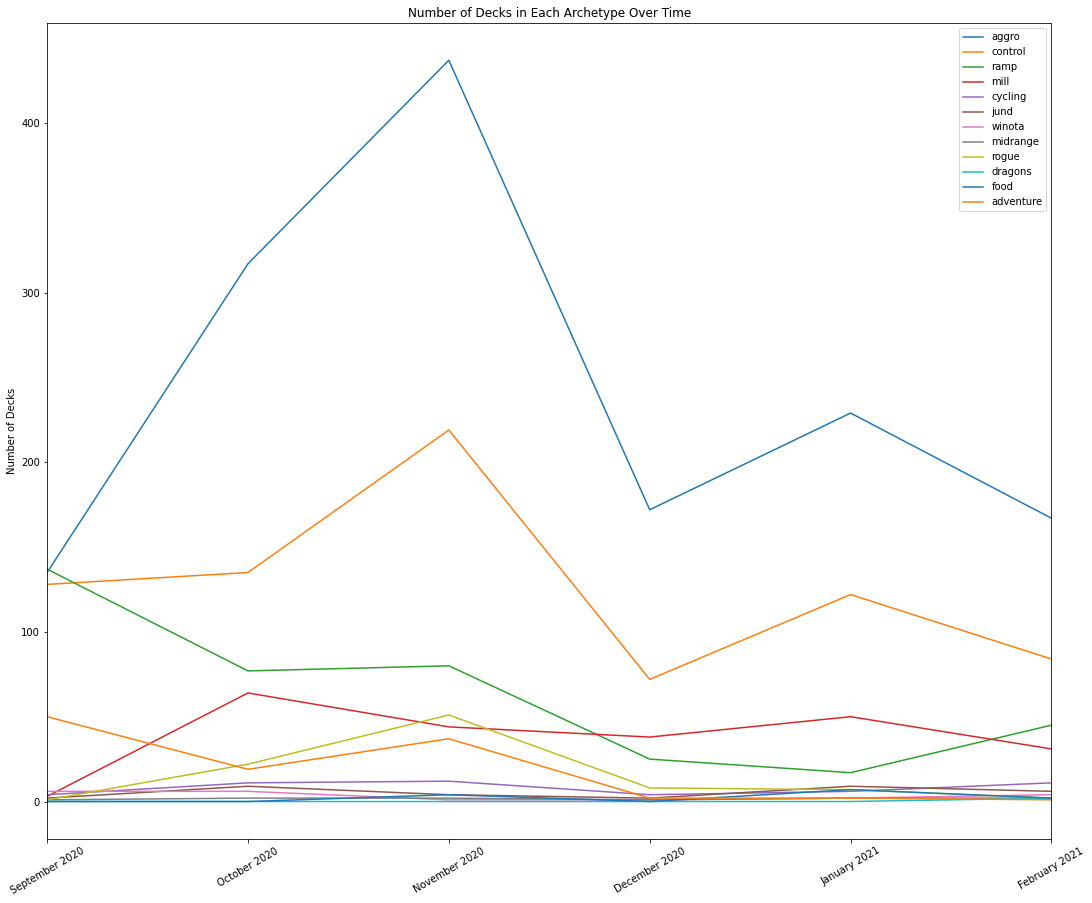

In [29]:
def archetypes_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.title("Number of Decks in Each Archetype Over Time")
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.ylabel("Number of Decks")
    plt.legend()
    if show:
        plt.show()
    
archetypes_over_time(full_table, show=True)

In [30]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [31]:
arena_vs_nonarena(full_table)

0.0

In [32]:
masked_table = full_table.copy()

In [33]:
cat_count = masked_table["category"].value_counts()

In [34]:
cat_count

gruul         15090
dimir         14421
mono green     6403
esper          6233
4-color        6066
sultai         5657
rakdos         5332
temur          4550
mono red       3977
izzet          2898
boros          2364
azorius        1927
golgari        1585
selesnya       1358
mono white     1219
naya           1040
jund           1002
mono black      820
grixis          773
abzan           753
orzhov          437
jeskai          424
bant            295
simic           268
mono blue       253
mardu           135
colorless        94
5-color          75
Name: category, dtype: int64

In [35]:
mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

In [36]:
mask

0        False
1        False
2        False
3        False
4        False
         ...  
85444     True
85445     True
85446     True
85447     True
85448     True
Name: category, Length: 85449, dtype: bool

In [37]:
masked_table["category"][mask] = "other"

<ipython-input-37-367f14b33268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


In [38]:
masked_table

eventId                              name_event       date  deckId  \
0            1                FNM @ MTG Arena Campania 2020-10-30       1   
1            1                FNM @ MTG Arena Campania 2020-10-30       1   
2            1                FNM @ MTG Arena Campania 2020-10-30       1   
3            1                FNM @ MTG Arena Campania 2020-10-30       1   
4            1                FNM @ MTG Arena Campania 2020-10-30       1   
...        ...                                     ...        ...     ...   
85444      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3180   
85445      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3180   
85446      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3180   
85447      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3180   
85448      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3180   

       pilotId     name_deck firstName  lastName  cardId  \
0            3   Gruul Aggro    Antimo  Morlando  261znr   
1            3   Gruul Aggro    Antimo  Morlando  244eld   
2            3   Gruul Aggro    Antimo  Morlando  266eld   
3            3   Gruul Aggro    Antimo  Morlando  262eld   
4            3   Gruul Aggro    Antimo  Morlando  115eld   
...        ...           ...       ...       ...     ...   
85444     1199  Weenie White  Marcello    Santos  233eld   
85445     1199  Weenie White  Marcello    Santos  004thb   
85446     1199  Weenie White  Marcello    Santos  019thb   
85447     1199  Weenie White  Marcello    Santos  318znr   
85448     1199  Weenie White  Marcello    Santos  036thb   

                                           name  count color slot archetype  \
0      Cragcrown Pathway // Timbercrown Pathway      4    GR   md     aggro   
1                                Fabled Passage      4   NaN   md     aggro   
2                                        Forest      9     G   md     aggro   
3                                      Mountain      5     R   md     aggro   
4                    Bonecrusher Giant // Stomp      4     R   md     aggro   
...                                         ...    ...   ...  ...       ...   
85444                        Sorcerous Spyglass      2   NaN   sb     aggro   
85445                           Banishing Light      3     W   sb     aggro   
85446                     Heliod's Intervention      2     W   sb     aggro   
85447                              Legion Angel      3     W   sb     aggro   
85448                           Sentinel's Eyes      3     W   sb     aggro   

      category       latest_set  
0        gruul  Zendikar Rising  
1        gruul  Zendikar Rising  
2        gruul  Zendikar Rising  
3        gruul  Zendikar Rising  
4        gruul  Zendikar Rising  
...        ...              ...  
85444    other         Kaldheim  
85445    other         Kaldheim  
85446    other         Kaldheim  
85447    other         Kaldheim  
85448    other         Kaldheim  

[85449 rows x 16 columns]

In [39]:
masked_table["category"].value_counts()

gruul         15090
dimir         14421
other         12458
mono green     6403
esper          6233
4-color        6066
sultai         5657
rakdos         5332
temur          4550
mono red       3977
izzet          2898
boros          2364
Name: category, dtype: int64

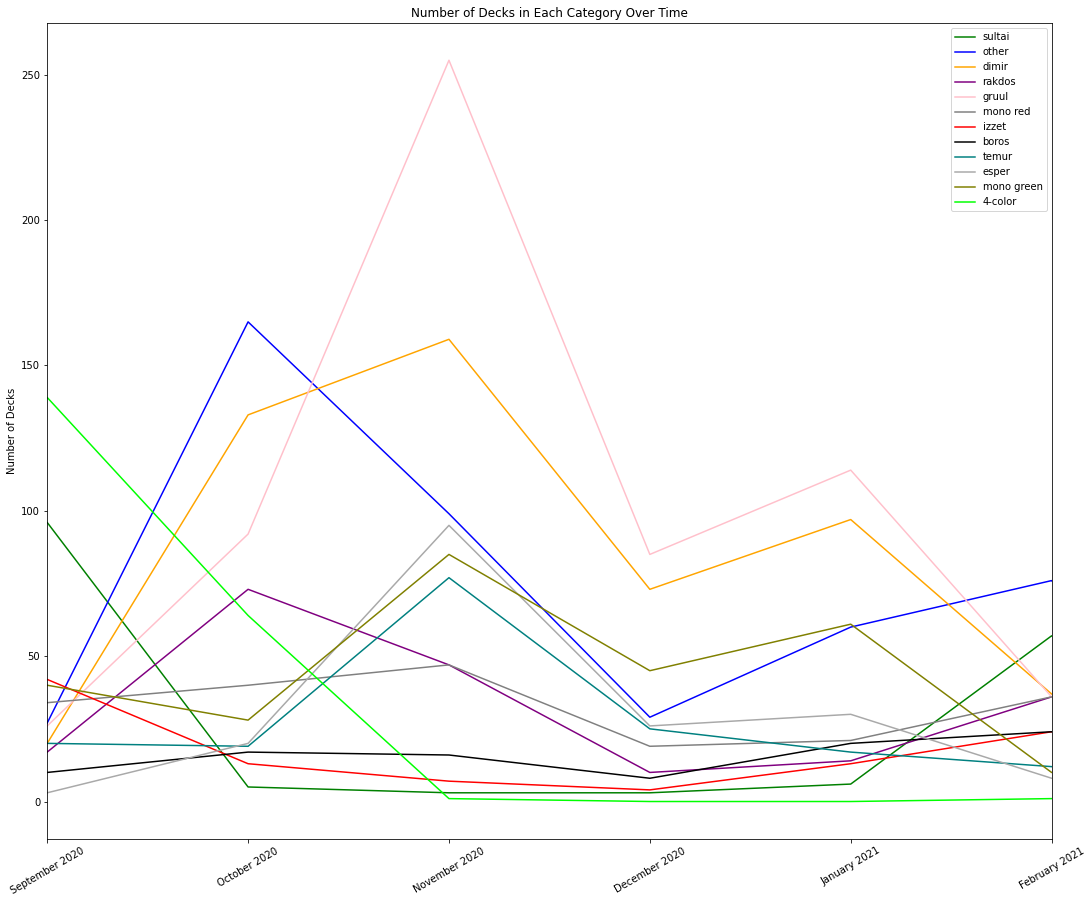

In [40]:
categories_over_time(masked_table)

In [41]:
def color_dominance(df, color, show=False):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    if show:
        plt.show()

In [42]:
def plot_color_dominance(df, show=False, pdf=None):
    for color in ["W", "U", "B", "R", "G"]:
        color_dominance(df, color, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

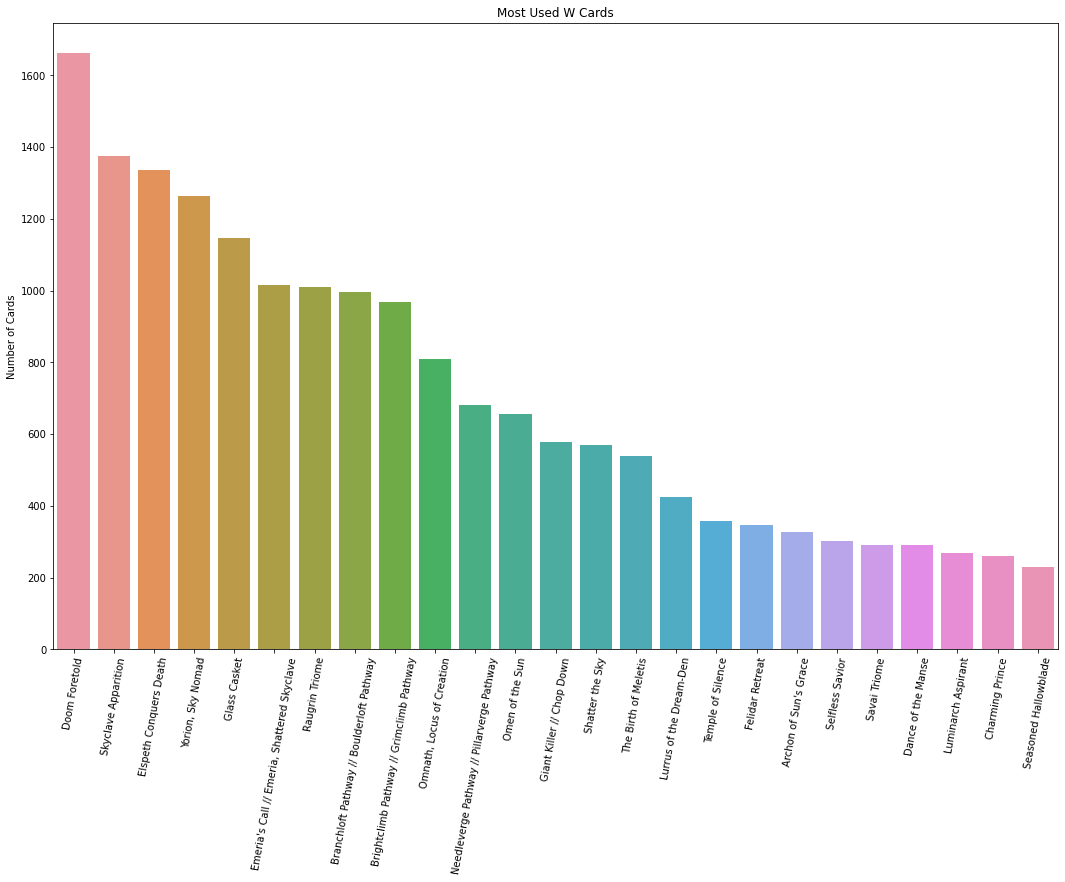

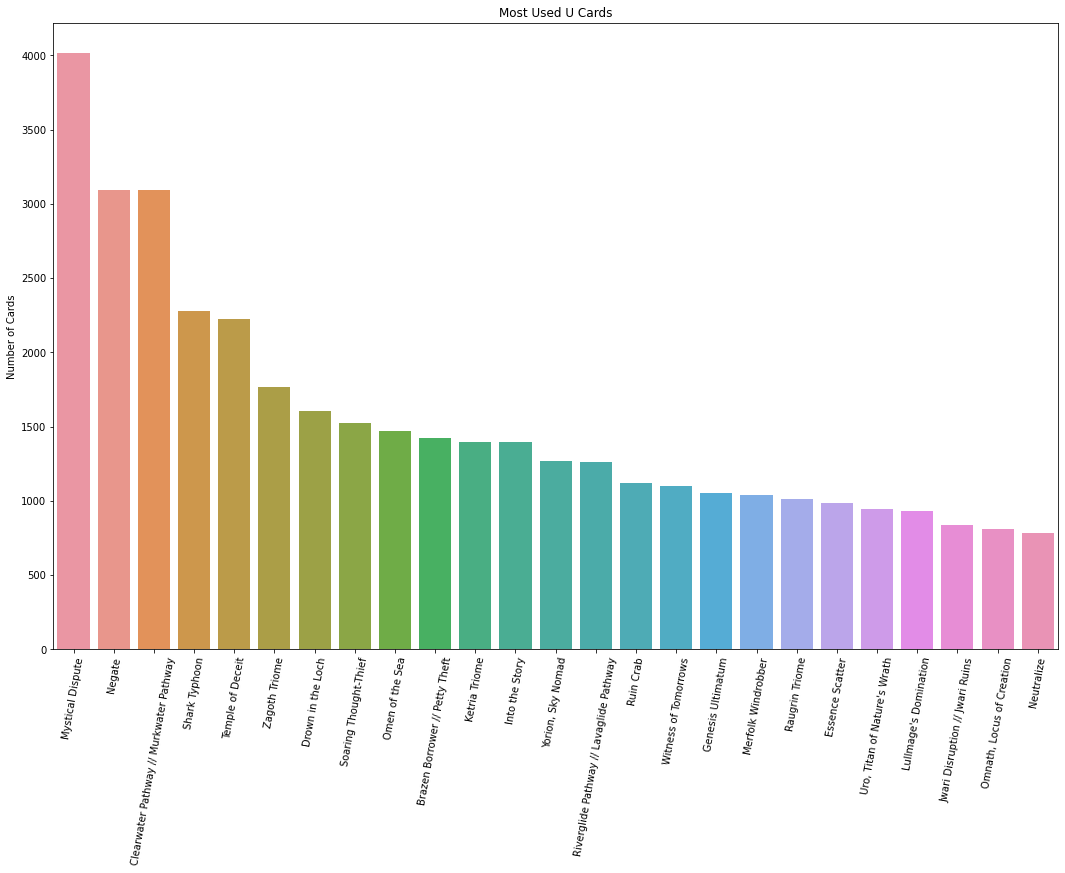

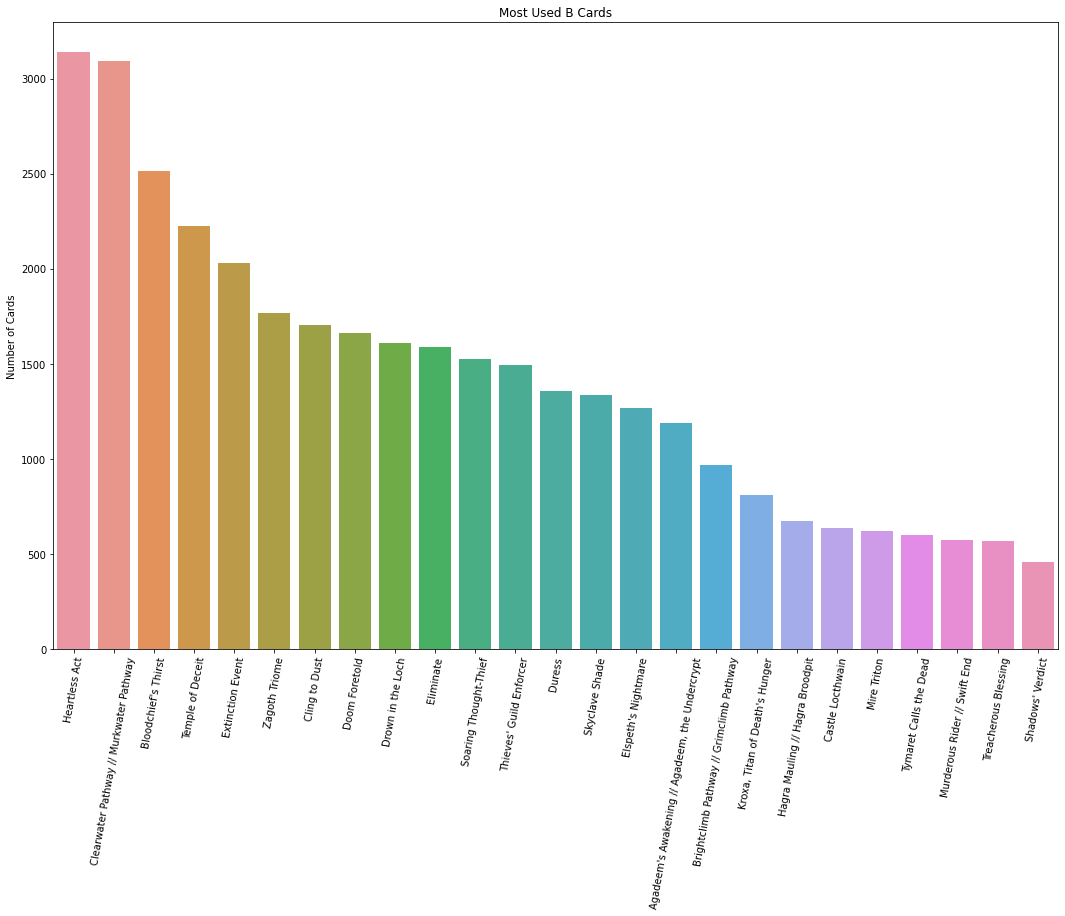

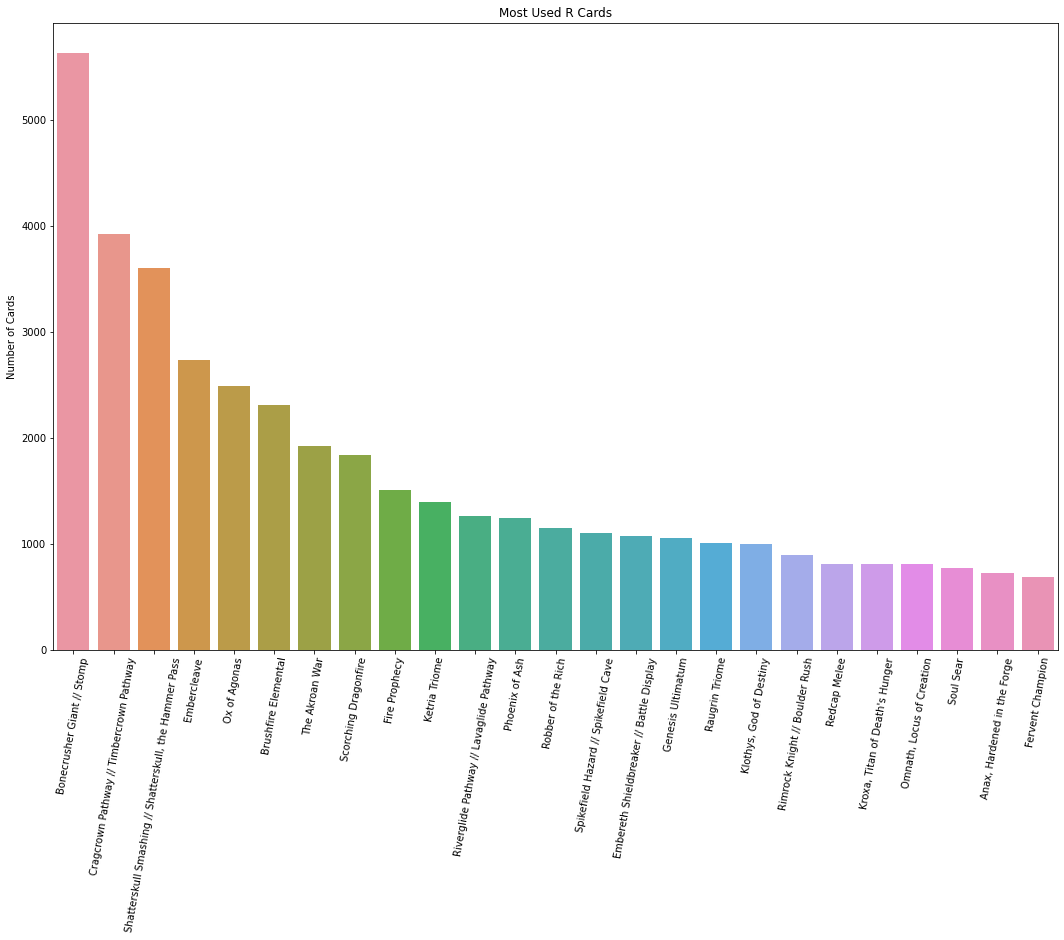

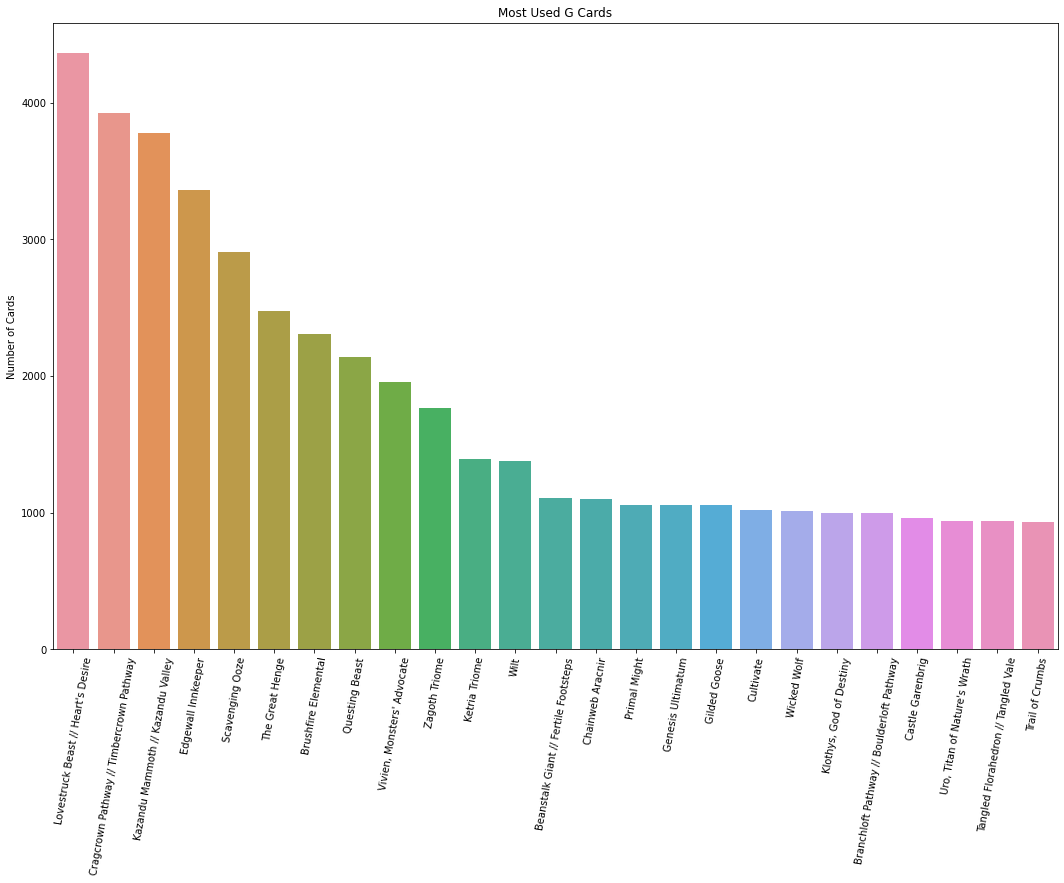

In [43]:
plot_color_dominance(full_table, show=True)

In [44]:
def set_dominance(df, set_code, show=False):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()

In [45]:
def plot_set_dominance(df, show=False, pdf=None):
    for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
        set_dominance(df, set_code, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

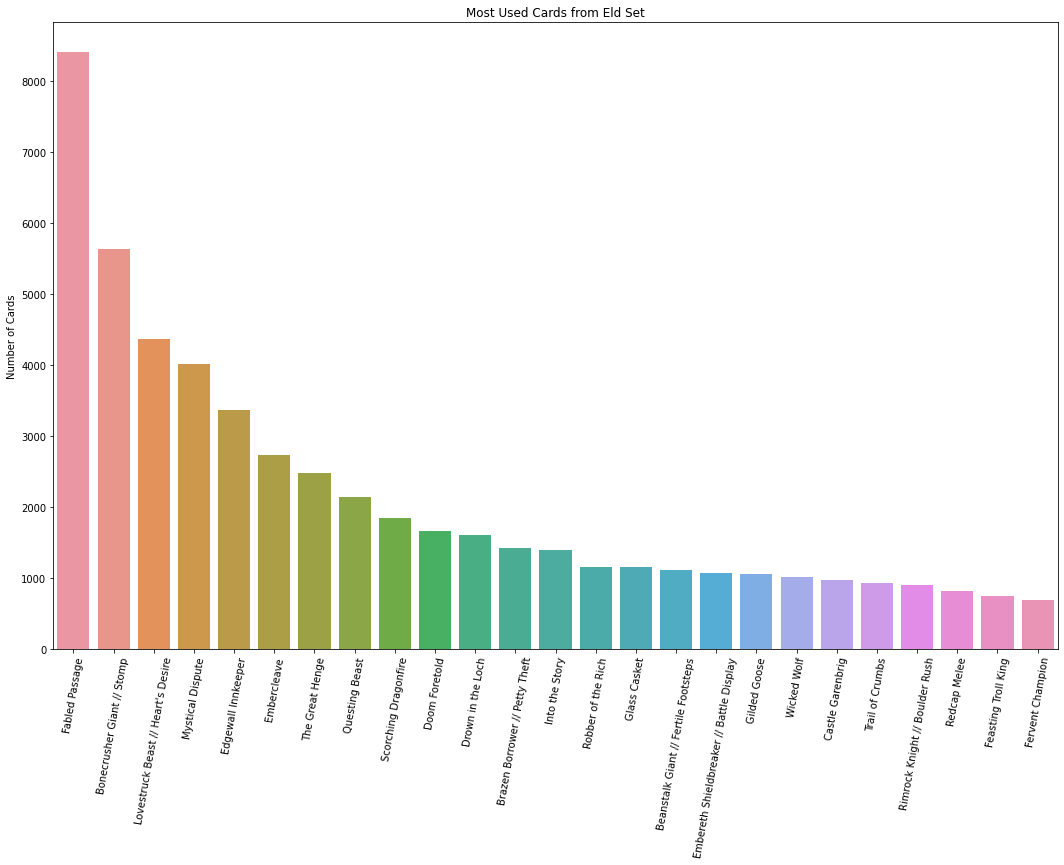

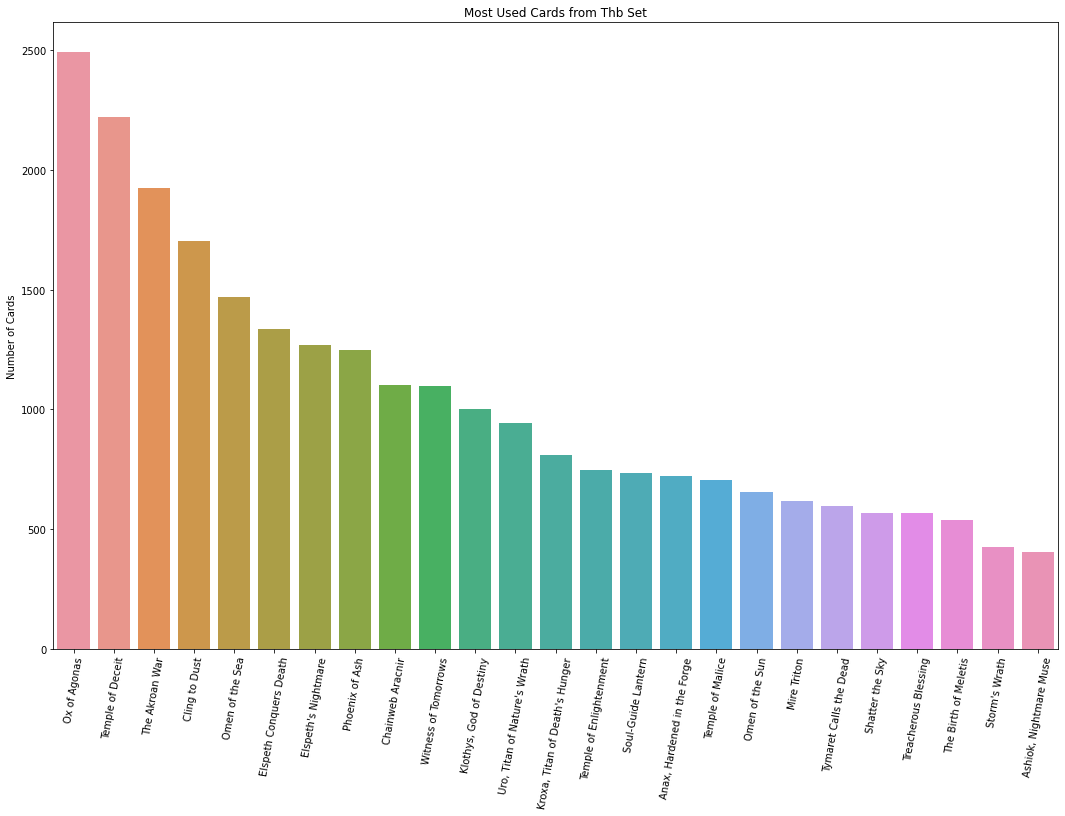

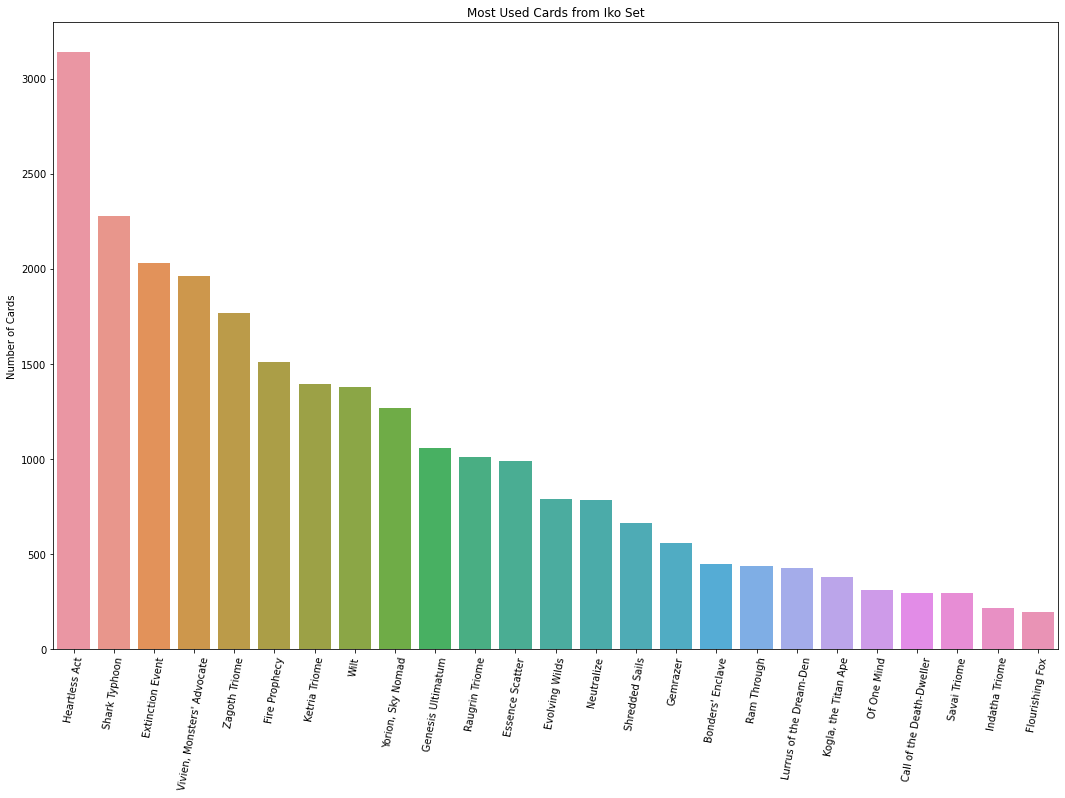

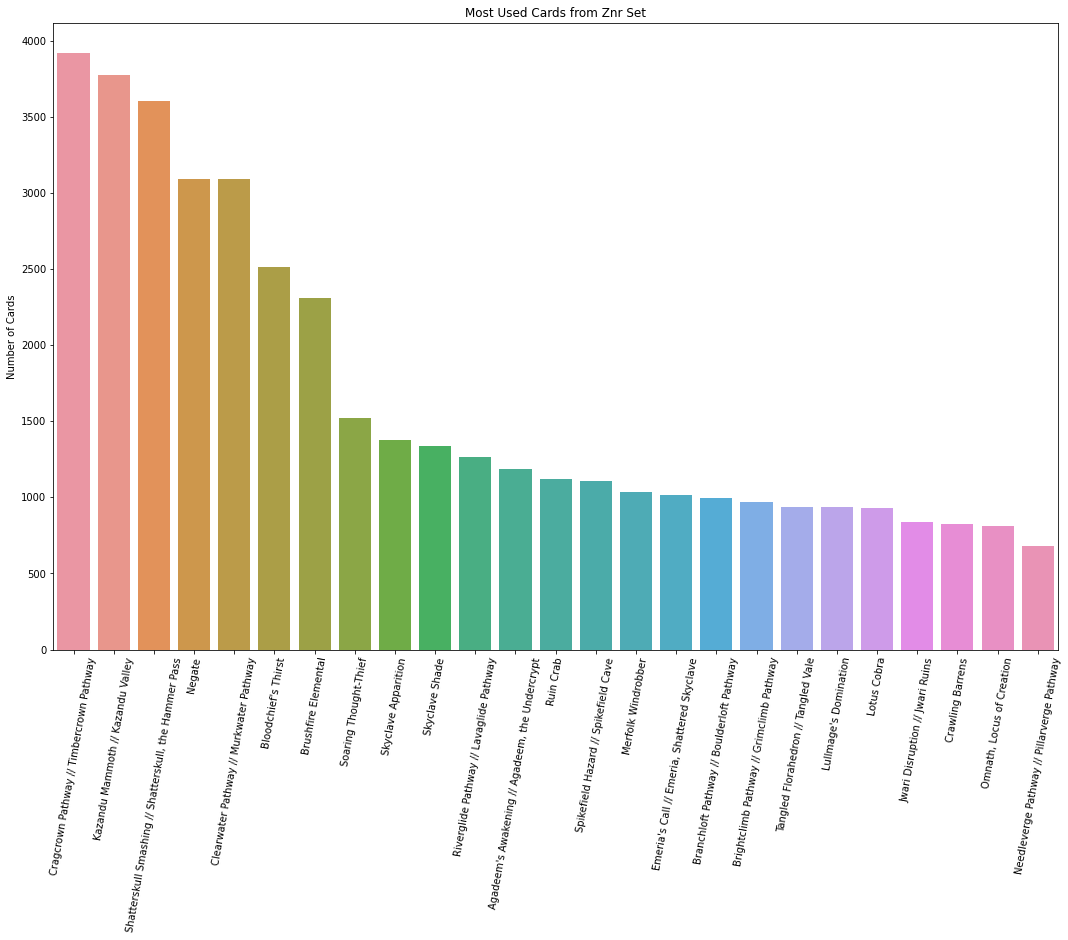

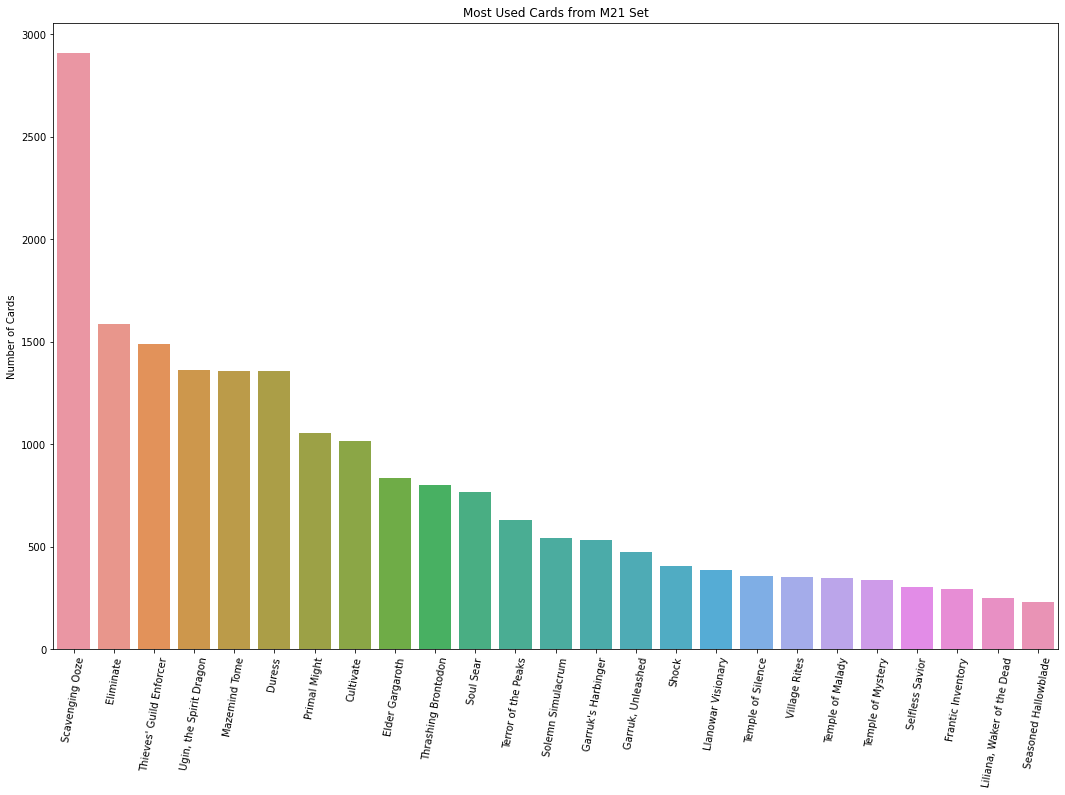

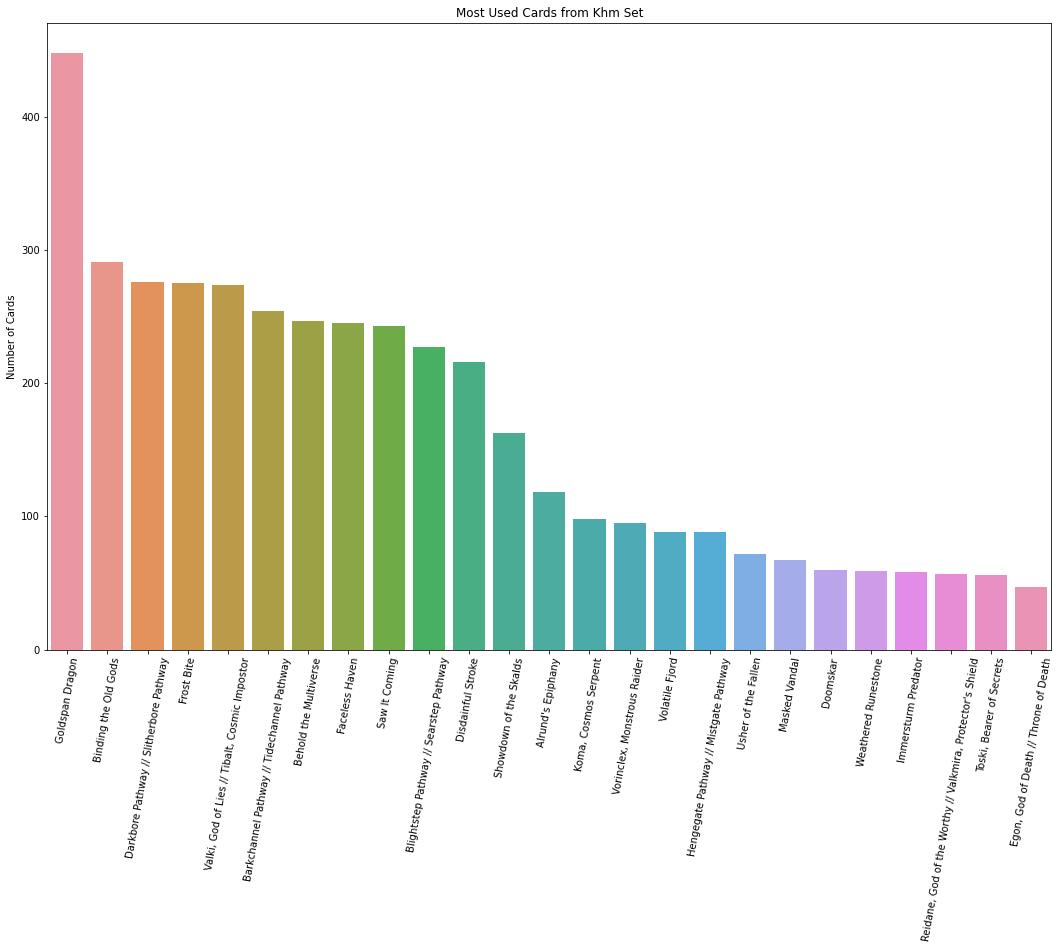

In [46]:
plot_set_dominance(full_table, show=True)

In [47]:
def oracle_text_analysis(df=most_used_cards):
    this_df = (
        df[["name"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return this_df[
        (~this_df["name"].str.contains("Triome|Pathway|Fabled Passage", regex=True))
    ]

In [48]:
oracle_texts = oracle_text_analysis()

In [49]:
oracle_texts

name  \
4                                     Bonecrusher Giant // Stomp   
6         Shatterskull Smashing // Shatterskull, the Hammer Pass   
8                             Lovestruck Beast // Heart's Desire   
10                             Kazandu Mammoth // Kazandu Valley   
12                                               The Great Henge   
14                                                 Heartless Act   
18                                                   Embercleave   
20                                               Scavenging Ooze   
25                                            Edgewall Innkeeper   
26                                           Bloodchief's Thirst   
28                                              Temple of Deceit   
31                                                Questing Beast   
33                                           Brushfire Elemental   
37                                    Vivien, Monsters' Advocate   
39                Agadeem's Awakening // Agadeem, the Undercrypt   
41                                                     Eliminate   
43                                             Drown in the Loch   
44                                              Extinction Event   
46                                              Castle Locthwain   
48                                         Soaring Thought-Thief   
49                                               Essence Scatter   
55                                       Thieves' Guild Enforcer   
57                                                Into the Story   
58                                                 Cling to Dust   
59                                              Crawling Barrens   
61                                                 Shark Typhoon   
63                                               Omen of the Sea   
64                                                The Akroan War   
65                   Emeria's Call // Emeria, Shattered Skyclave   
67                               Hagra Mauling // Hagra Broodpit   
69                                           Skyclave Apparition   
71                                        Elspeth Conquers Death   
72                                                 Mazemind Tome   
74                                           Elspeth's Nightmare   
75                                                  Primal Might   
77                                                 Fire Prophecy   
78                                                        Negate   
91                                       Ugin, the Spirit Dragon   
95                                             Yorion, Sky Nomad   
97                                Brazen Borrower // Petty Theft   
101                                           Merfolk Windrobber   
102                               Rimrock Knight // Boulder Rush   
104                              Jwari Disruption // Jwari Ruins   
105                                                    Ruin Crab   
107                         Spikefield Hazard // Spikefield Cave   
108                                           Robber of the Rich   
110                                                 Gilded Goose   
112                          Tangled Florahedron // Tangled Vale   
115                                                 Glass Casket   
117                                               Evolving Wilds   
126                                              Trail of Crumbs   
127                                                  Wicked Wolf   
129                                             Castle Garenbrig   
131                                              Castle Vantress   
133                                              Omen of the Sun   
134                                             Mystical Dispute   
135                     Embereth Shieldbreaker // Battle Display   
137                                        Lullmage's Domination   
138                                             

In [50]:
help(wordnet.synsets)

Help on method synsets in module nltk.corpus.reader.wordnet:

synsets(lemma, pos=None, lang='eng', check_exceptions=True) method of nltk.corpus.reader.wordnet.WordNetCorpusReader instance
    Load all synsets with a given lemma and part of speech tag.
    If no pos is specified, all synsets for all parts of speech
    will be loaded.
    If lang is specified, all the synsets associated with the lemma name
    of that language will be returned.



In [51]:
wordnet.synsets("enter")

[Synset('enter.v.01'),
 Synset('enter.v.02'),
 Synset('enroll.v.01'),
 Synset('figure.v.02'),
 Synset('record.v.01'),
 Synset('enter.v.06'),
 Synset('accede.v.02'),
 Synset('insert.v.01'),
 Synset('embark.v.02')]

In [52]:
def get_part_of_speech(word):
    
    # wordnet.synsets(word) returns a list of all the available synonyms in ntlk corpus
    probable_part_of_speech = wordnet.synsets(word)

    pos_counts = Counter()
    
    # Gets the number of times each word is labeled as "n", "v", "a", or "r" in synsets
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    
    # The most common item in Counter is the one with the most synsets of a particular pos
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

In [53]:
def process_text(text):
    cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', "", text)
    tokenized = word_tokenize(cleaned)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    return [word.lower() for word in lemmatized if word not in stop_words]

In [54]:
def get_tf_idf_scores(corpus):
    processed_corpus = [process_text(text) for text in corpus]
    vectorizer = TfidfVectorizer(norm=None, lowercase=None)
    tfidf_scores = vectorizer.fit_transform(processed_corpus)
    return tfidf_scores

In [55]:
texts = oracle_texts["oracle_text"].fillna("").tolist()
# processed_texts = [process_text(text) for text in texts]

In [56]:
texts

["Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.",
 "Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don't, it enters the battlefield tapped.\n{T}: Add {R}.",
 "Lovestruck Beast can't attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.)",
 'Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}.',
 'This spell costs {X} less to cast, where X is the greatest power amon

In [57]:
test_vectorizer = TfidfVectorizer(norm=None, stop_words=stopwords.words("english"))
tfidf_scores = test_vectorizer.fit_transform(texts)

In [58]:
test_vectorizer.get_feature_names()

['10',
 '15',
 '20',
 'abandon',
 'abilities',
 'ability',
 'able',
 'acclaimed',
 'acolyte',
 'acquisitions',
 'activate',
 'activated',
 'adamant',
 'add',
 'addition',
 'additional',
 'adds',
 'adventure',
 'affected',
 'affliction',
 'agadeem',
 'agonas',
 'akoum',
 'akroan',
 'aldergard',
 'alirios',
 'ally',
 'almighty',
 'alrund',
 'alseid',
 'also',
 'among',
 'amount',
 'amulet',
 'anax',
 'ancient',
 'ancients',
 'angel',
 'angels',
 'another',
 'anything',
 'anywhere',
 'ape',
 'apex',
 'apparition',
 'apply',
 'apprentice',
 'aracnir',
 'arcanist',
 'archfiend',
 'archmage',
 'archon',
 'archpriest',
 'arctic',
 'ardenvale',
 'aris',
 'arni',
 'arsonist',
 'artifact',
 'artifacts',
 'artisan',
 'ascendant',
 'ash',
 'ashaya',
 'ashiok',
 'asphodel',
 'aspirant',
 'assign',
 'athreos',
 'atris',
 'attach',
 'attached',
 'attack',
 'attacked',
 'attacking',
 'attacks',
 'aura',
 'axe',
 'ayara',
 'backwater',
 'bala',
 'baloth',
 'banishing',
 'banner',
 'bargain',
 'barrage'

In [59]:
test_vectorizer.vocabulary_

{'whenever': 1165,
 'bonecrusher': 130,
 'giant': 450,
 'becomes': 101,
 'target': 1025,
 'spell': 970,
 'deals': 260,
 'damage': 252,
 'controller': 214,
 'prevented': 793,
 'turn': 1089,
 'stomp': 995,
 'shatterskull': 923,
 'smashing': 954,
 'divided': 288,
 'choose': 181,
 'among': 31,
 'two': 1097,
 'creatures': 242,
 'planeswalkers': 777,
 'twice': 1096,
 'instead': 551,
 'hammer': 497,
 'pass': 756,
 'enters': 348,
 'battlefield': 95,
 'may': 655,
 'pay': 758,
 'life': 609,
 'tapped': 1023,
 'add': 13,
 'lovestruck': 632,
 'beast': 99,
 'attack': 72,
 'unless': 1113,
 'control': 212,
 'creature': 241,
 'create': 239,
 'white': 1168,
 'human': 528,
 'token': 1056,
 'exile': 370,
 'card': 150,
 'cast': 155,
 'later': 598,
 'landfall': 594,
 'land': 593,
 'kazandu': 571,
 'mammoth': 645,
 'gets': 445,
 'end': 341,
 'valley': 1126,
 'costs': 226,
 'less': 604,
 'greatest': 478,
 'power': 787,
 'gain': 429,
 'nontoken': 721,
 'put': 804,
 'counter': 229,
 'draw': 302,
 'one': 732,
 '

In [60]:
corpus = " ".join(oracle_texts["oracle_text"].fillna(""))

In [61]:
corpus

'Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell\'s controller. // Damage can\'t be prevented this turn. Stomp deals 2 damage to any target. Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don\'t, it enters the battlefield tapped.\n{T}: Add {R}. Lovestruck Beast can\'t attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.) Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}. This spell costs {X} less to cast, where X is the greatest power among creatures y

In [62]:
def make_ngram_df(text_series, n):
    text_series = text_series.fillna("")
    text = " ".join(text_series)
#     cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', '', text)
#     tokenized = word_tokenize(cleaned)
    
#     lemmatizer = WordNetLemmatizer()
#     lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    
#     stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    real_text = process_text(text)
    
    bigrams = [" ".join(gram) for gram in ngrams(real_text, n)]
    
    freq = Counter(bigrams)
    
    df = (
        pd.DataFrame(
            {
                "bigram": freq.keys(),
                "freq": freq.values()
            }
        )
        .sort_values(by="freq", ascending=False)
        .iloc[:100]
    )
    df["pct_total"] = df["freq"] / df["freq"].sum() * 100
    
    return df

In [63]:
bigrams = make_ngram_df(oracle_texts["oracle_text"], 2)

In [64]:
bigrams

bigram  freq  pct_total
43        enter battlefield   293   7.123754
28          target creature   186   4.522247
88                 end turn   126   3.063457
119               draw card   126   3.063457
73                  you may   112   2.723073
53                    t add   107   2.601507
104        creature control   104   2.528568
117            +1+1 counter   102   2.479942
153          card graveyard    93   2.261123
51          battlefield tap    92   2.236810
68           creature token    86   2.090931
184               mana cost    69   1.677608
179              cast spell    62   1.507416
202            card library    58   1.410163
415            discard card    58   1.410163
459        opponent control    53   1.288597
183            convert mana    53   1.288597
346                two card    51   1.239971
897                at begin    51   1.239971
116                put +1+1    50   1.215658
74                 may cast    49   1.191345
82      battlefield control    45   1.094092
128          counter target    44   1.069779
142            creature get    43   1.045466
17            damage target    42   1.021152
277        onto battlefield    42   1.021152
156           creature card    41   0.996839
123          destroy target    41   0.996839
162                  1 life    41   0.996839
45                  may pay    39   0.948213
71               exile card    38   0.923900
181   creature planeswalker    38   0.923900
200                look top    36   0.875274
749             t sacrifice    36   0.875274
52                    tap t    35   0.850960
327               card hand    34   0.826647
108                you gain    34   0.826647
271          search library    34   0.826647
1126      whenever creature    32   0.778021
279         shuffle library    31   0.753708
47                   3 life    31   0.753708
337             control get    31   0.753708
207          bottom library    31   0.753708
203             library you    31   0.753708
163           whenever cast    30   0.729395
204                 may put    30   0.729395
143                get +1+1    30   0.729395
467             deal damage    30   0.729395
157                card put    28   0.680768
216              cant block    28   0.680768
221           combat damage    28   0.680768
151            exile target    27   0.656455
121              choose one    27   0.656455
75            cast creature    27   0.656455
4              target spell    27   0.656455
559         target opponent    27   0.656455
532           return target    26   0.632142
628                put hand    26   0.632142
416               card draw    26   0.632142
205                put card    26   0.632142
110                  2 life    26   0.632142
664           damage player    25   0.607829
676        activate ability    25   0.607829
161                  gain 1    25   0.607829
64                create 11    25   0.607829
694              three card    25   0.607829
98                less cast    24   0.583516
2736       enchant creature    24   0.583516
658              owner hand    24   0.583516
775               land card    23   0.559203
201                top card    23   0.559203
229             deal combat    22   0.534889
408               token fly    22   0.534889
195                tap when    21   0.510576
1396      nonhuman creature    21   0.510576
65                 11 white    21   0.510576
501              one target    21   0.510576
1101               x number    21   0.510576
94               this spell    20   0.486263
1319             put target    20   0.486263
490              basic land    20   0.486263
331                 as long    20   0.486263
218          creature power    20   0.486263
379               cast card    20   0.486263
371                  gain 3    20   0.486263
92                    add g    20   0.486263
427                  scry 2    19   0.461950
300            equal number    19   0.461950
282   graveyard 

In [65]:
trigrams = make_ngram_df(oracle_texts["oracle_text"], 3)

In [66]:
trigrams

bigram  freq  pct_total
55           enter battlefield tap    75   3.914405
207              convert mana cost    53   2.766180
125               put +1+1 counter    50   2.609603
78                    you may cast    42   2.192067
155        target creature control    38   1.983299
87       enter battlefield control    37   1.931106
56               battlefield tap t    35   1.826722
57                       tap t add    34   1.774530
230                library you may    29   1.513570
204   target creature planeswalker    27   1.409186
229               card library you    26   1.356994
179                    gain 1 life    25   1.304802
505                 card draw card    24   1.252610
132        destroy target creature    23   1.200418
504              discard card draw    23   1.200418
831           combat damage player    23   1.200418
263             deal combat damage    22   1.148225
495             creature token fly    22   1.148225
220           battlefield tap when    21   1.096033
228               top card library    21   1.096033
138        counter target creature    20   1.043841
460                  may cast card    20   1.043841
449                    gain 3 life    20   1.043841
98                         t add g    20   1.043841
1013           rest bottom library    19   0.991649
458             card graveyard you    19   0.991649
3291               at begin upkeep    19   0.991649
1032       indestructible end turn    18   0.939457
86          land enter battlefield    18   0.939457
77                    card you may    18   0.939457
231                    you may put    18   0.939457
117                    gain 2 life    18   0.939457
323           put onto battlefield    18   0.939457
342                        t add b    17   0.887265
535         lore counter sacrifice    17   0.887265
85             whenever land enter    17   0.887265
729         damage target creature    17   0.887265
532                  draw step add    17   0.887265
534               add lore counter    17   0.887265
531                enter draw step    17   0.887265
533                  step add lore    17   0.887265
530                saga enter draw    17   0.887265
1706          library random order    17   0.887265
529                  as saga enter    17   0.887265
1705         bottom library random    17   0.887265
237                        t add u    17   0.887265
8                    deal 2 damage    17   0.887265
79               may cast creature    17   0.887265
1346        enter battlefield draw    16   0.835073
855            target creature get    16   0.835073
981                basic land card    16   0.835073
793                time could cast    16   0.835073
459              graveyard you may    16   0.835073
536          counter sacrifice iii    16   0.835073
537                sacrifice iii i    16   0.835073
101                this spell cost    16   0.835073
1830       creature card graveyard    16   0.835073
351           counter target spell    15   0.782881
143                    cost 1 less    15   0.782881
84          landfall whenever land    15   0.782881
2177           +1+1 counter target    15   0.782881
69                 create 11 white    15   0.782881
461            cast card graveyard    15   0.782881
75                 then exile card    15   0.782881
76                  exile card you    15   0.782881
197                    you may pay    15   0.782881
80              cast creature late    15   0.782881
720            one target creature    15   0.782881
944                     you gain 3    15   0.782881
81             creature late exile    15   0.782881
332           target creature card    15   0.782881
462          card graveyard escape    15   0.782881
463          graveyard escape cost    15   0.782881
227                  look top card    15   0.782881
2111                     may pay 2    15   0.782881
1279                   lose 1 life    15   0.782881
1940      target nonhuma

In [67]:
unigrams = make_ngram_df(oracle_texts["oracle_text"], 1)

In [68]:
unigrams

bigram  freq  pct_total
21       creature   694   6.071210
54           card   662   5.791269
4          target   395   3.455516
32    battlefield   383   3.350538
46        control   381   3.333042
31          enter   312   2.729420
12           turn   256   2.239524
75            put   234   2.047065
56           cast   219   1.915843
77        counter   213   1.863354
33            may   202   1.767124
5           spell   197   1.723384
85           when   188   1.644651
39              t   188   1.644651
0        whenever   186   1.627154
78           draw   183   1.600910
114       library   175   1.530925
55            you   174   1.522177
53          exile   171   1.495932
93      graveyard   160   1.399703
73           gain   157   1.373458
68           cost   149   1.303473
125      opponent   147   1.285977
36           life   146   1.277229
64            end   146   1.277229
40            add   145   1.268480
7               2   141   1.233488
84              1   139   1.215992
8          damage   139   1.215992
76           +1+1   133   1.163503
157          hand   132   1.154755
24             if   129   1.128510
6            deal   129   1.128510
107          mana   127   1.111014
38            tap   123   1.076021
62            get   116   1.014784
51          token   116   1.014784
196     sacrifice   116   1.014784
20            two   112   0.979792
48         create   111   0.971044
127        player   105   0.918555
79            one   102   0.892310
224     permanent    94   0.822325
16              x    93   0.813577
59           land    86   0.752340
113           top    86   0.752340
35              3    81   0.708599
190       discard    76   0.664859
269       ability    72   0.629866
44         attack    71   0.621118
142        number    70   0.612370
69           less    69   0.603622
141        return    68   0.594874
18         choose    68   0.594874
34            pay    67   0.586125
10           cant    65   0.568629
158        flying    61   0.533637
436        mutate    60   0.524888
167       another    59   0.516140
71          power    58   0.507392
80        destroy    57   0.498644
28             as    54   0.472400
106       convert    53   0.463651
262         begin    53   0.463651
105  planeswalker    52   0.454903
156          lose    51   0.446155
322            at    51   0.446155
290      artifact    51   0.446155
146         equal    51   0.446155
82          three    47   0.411163
49          white    46   0.402414
187           fly    45   0.393666
123        combat    45   0.393666
91        trample    44   0.384918
122         block    44   0.384918
139          onto    44   0.384918
198          step    43   0.376170
233        reveal    43   0.376170
344   enchantment    42   0.367422
279           die    42   0.367422
481       enchant    42   0.367422
120         haste    41   0.358674
111          scry    40   0.349926
245         color    40   0.349926
47             11    40   0.349926
27        instead    39   0.341177
112          look    38   0.332429
268      activate    38   0.332429
138        search    36   0.314933
140       shuffle    36   0.314933
67           this    35   0.306185
108          kick    35   0.306185
330      lifelink    35   0.306185
37           dont    35   0.306185
19          among    35   0.306185
83          flash    35   0.306185
159          long    34   0.297437
9      controller    34   0.297437
163          mill    34   0.297437
177             4    34   0.297437

In [69]:
def topn_analyze_card_text_by_archetype(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        archetype_df = get_most_used_cards(df[df["archetype"]==archetype])
        oracle_text_df = oracle_text_analysis(archetype_df)
        bigrams = make_ngram_df(oracle_text_df["oracle_text"], 2)
        plt.figure(figsize=(18, 15))
        sns.barplot(data=bigrams.iloc[:10], x="bigram", y="pct_total")
        plt.title(f"Bigrams for {archetype.title()}")
        plt.xticks(rotation=80)
        plt.xlabel("")
        plt.ylabel("Percent of Total")
        if show:
            plt.show()
        if pdf:
            pdf.savefig()
            plt.close("all")

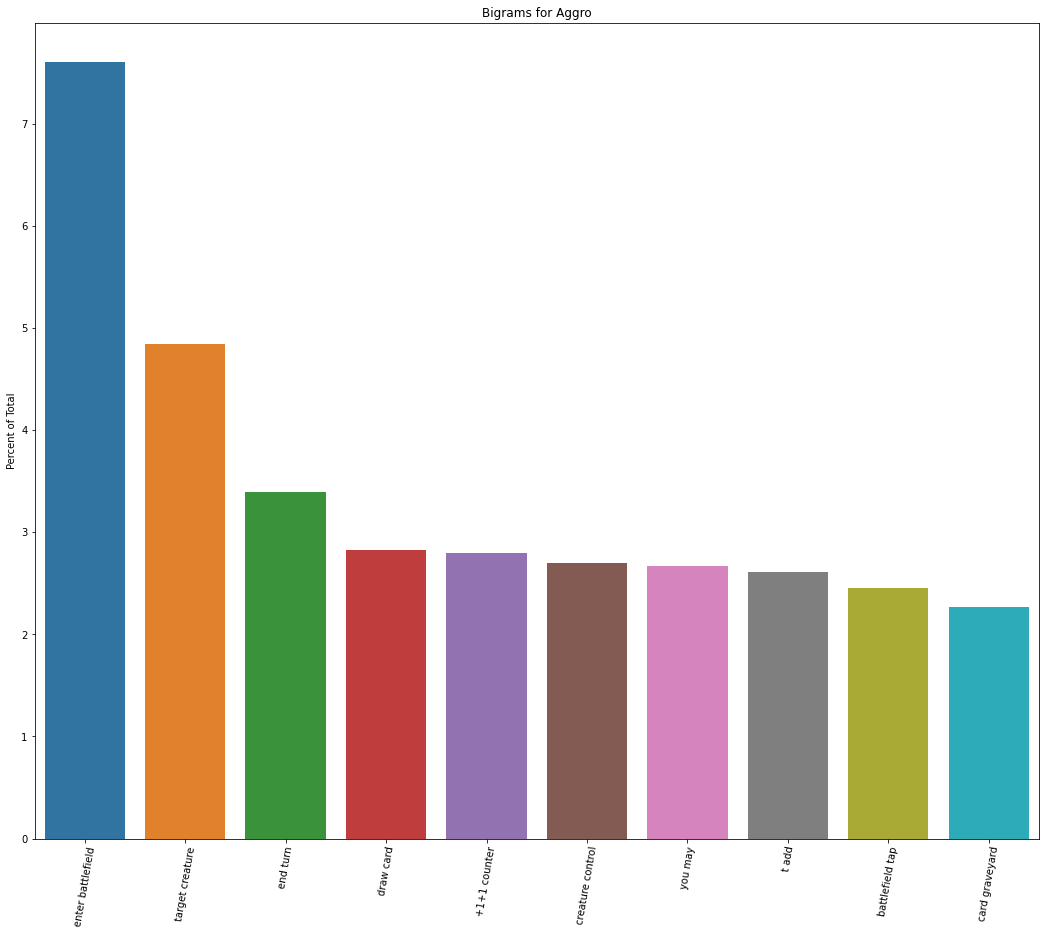

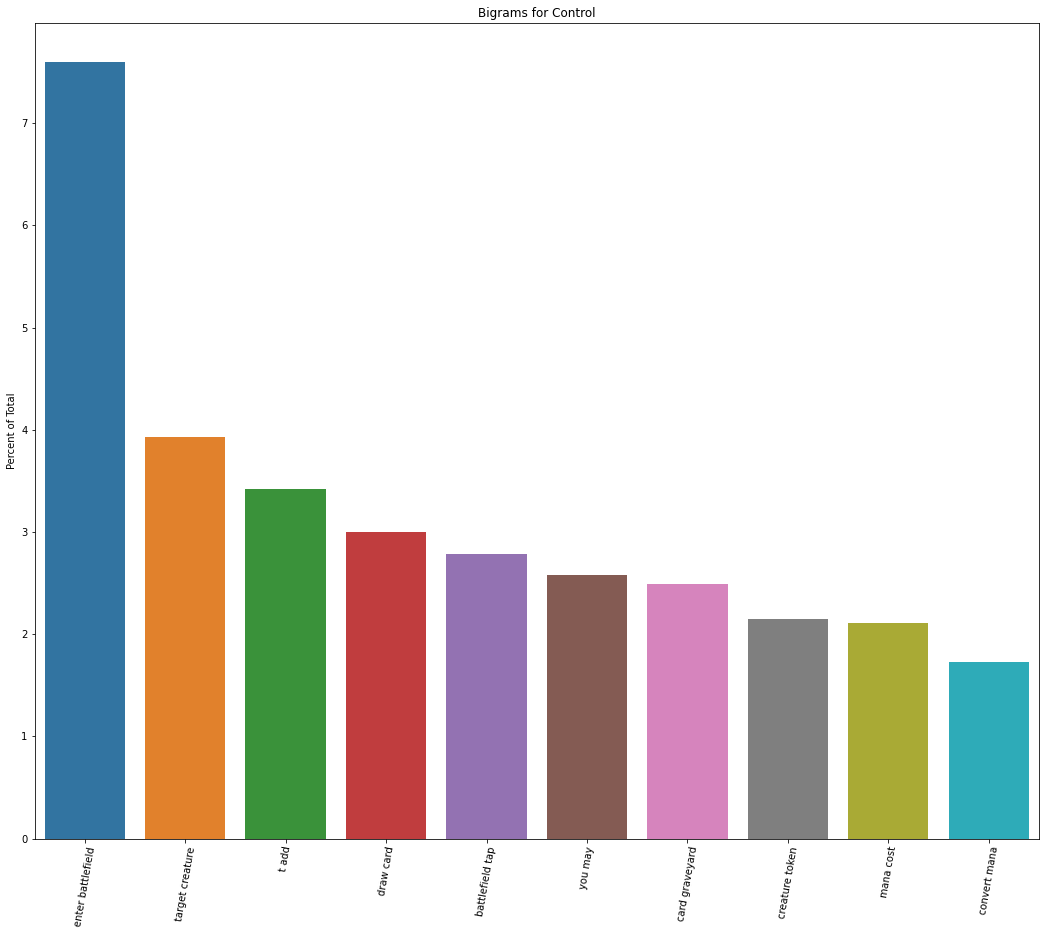

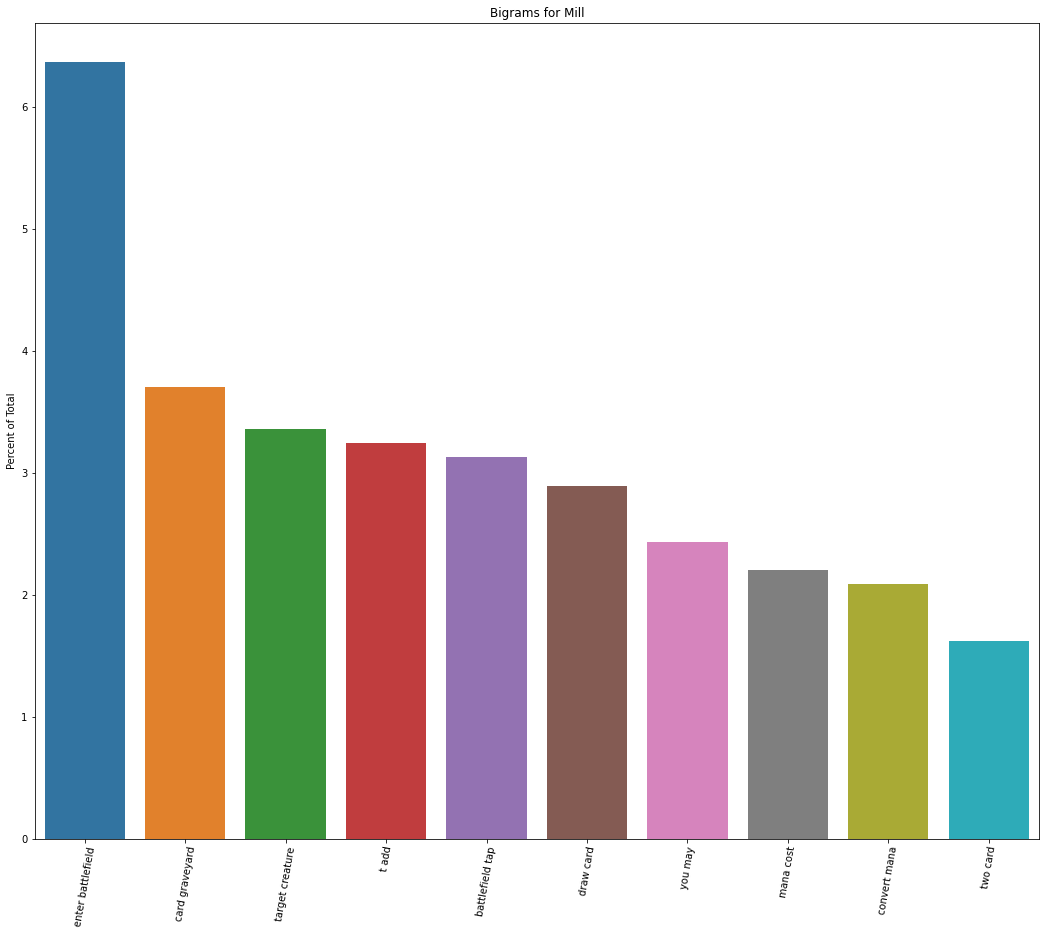

In [70]:
topn_analyze_card_text_by_archetype(main_decks, n=3, show=True)

In [71]:
oracle_texts[oracle_texts["oracle_text"].str.contains("\send\s.*\sturn[\s\.]", regex=True, flags=re.I)]

name  \
10        Kazandu Mammoth // Kazandu Valley   
33                      Brushfire Elemental   
59                         Crawling Barrens   
75                             Primal Might   
102          Rimrock Knight // Boulder Rush   
127                             Wicked Wolf   
165                    Kogla, the Titan Ape   
178                         Castle Embereth   
194                        Fervent Champion   
216                          Phoenix of Ash   
256                         Akoum Hellhound   
259                           Dream Trawler   
274                          Faceless Haven   
279                     Claim the Firstborn   
292                    Binding the Old Gods   
295                         Selfless Savior   
306                      Kargan Intimidator   
338                    Seasoned Hallowblade   
360                         Footfall Crater   
396                 Alseid of Life's Bounty   
404                  Elspeth, Sun's Nemesis   
419                               Soul Sear   
422                       Garruk, Unleashed   
476                     Immersturm Predator   
487                           Glory Bearers   
497                       Weaselback Redcap   
499                   Erebos's Intervention   
529              Kenrith, the Returned King   
530                         Felidar Retreat   
546                        The Royal Scions   
548                Winota, Joiner of Forces   
559                    Koma, Cosmos Serpent   
561                        Zulaport Duelist   
568                       Grasp of Darkness   
577                           Massacre Wurm   
589   Faerie Guidemother // Gift of the Fae   
608        Sejiri Shelter // Sejiri Glacier   
659                               Infuriate   
661                          Ranger's Guile   
666                Nissa of Shadowed Boughs   
683                          Blizzard Brawl   
693            Vito, Thorn of the Dusk Rose   
699                         Arni Brokenbrow   
702                            Fight as One   
715                             Shadowspear   
728                          Pestilent Haze   
740                          Snakeskin Veil   
751                     Firja's Retribution   
758                      Archpriest of Iona   
776                      Blacklance Paragon   
783    Song-Mad Treachery // Song-Mad Ruins   
787                               Basri Ket   
806                              Bolt Hound   
807       Makindi Stampede // Makindi Mesas   
808                         Bronzehide Lion   
816                      Fearless Fledgling   
819                            Fearless Pup   
832                        Wildwood Tracker   
838                    Reptilian Reflection   
860                           Crash Through   
871                            Raking Claws   
883             Beyeen Veil // Beyeen Coast   
884                  Watcher of the Spheres   
899                          Crippling Fear   
937                         Master of Winds   
939                      Almighty Brushwagg   
965                         Goblin Wizardry   
967                 Akiri, Fearless Voyager   
972                       Sea Gate Banneret   
976                       Witch's Vengeance   
996                           Canopy Baloth   
1030                         Shadow Stinger   
1046                          Discontinuity   
1050                    Heroic Intervention   
1058                      Masked Blackguard   
1069                            Igneous Cur   
1074                       Stormwing Entity   
1076                          Righteousness   
1090                            Grim Draugr   
1094                        Resolute Strike   
1110                             Riddleform   
1120                   Tentative Connection   
1127                         Defiant Strike   
1139                        Dauntless Unity   
1141                       Daybreak Charger 

In [72]:
full_table_oracle_text = oracle_text_analysis(full_table)

In [73]:
full_table_oracle_text

name  \
6                            Forest   
151                        Mountain   
296      Bonecrusher Giant // Stomp   
298             Brushfire Elemental   
300              Edgewall Innkeeper   
...                             ...   
1116525            Ascendant Spirit   
1116527              Cosmos Charger   
1139975            Gates of Istfell   
1141691            Funeral Longboat   
1143843              Clarion Spirit   

                                                                                                                                                                                                                                                                                                                                                                                                     oracle_text  
6                                                                                                                                                                                                                                                                                                                                                                                                ({T}: Add {G}.)  
151                                                                                                                                                                                                                                                                                                                                                                                              ({T}: Add {R}.)  
296                                                                                                                                                                                                           Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.  
298                                                                                                                                                                                                      Haste\nBrushfire Elemental can't be blocked by creatures with power 2 or less.\nLandfall — Whenever a land enters the battlefield under your control, Brushfire Elemental gets +2/+2 until end of turn.  
300                                                                                                                                                                                                                                                                                Whenever you cast a creature spell that has an Adventure, draw a card. (It doesn't need to have gone on the adventure first.)  
...                                                                                                                                                                                                                                                                                                                                                                                                          ...  
1116525  {S}{S}: Ascendant Spirit becomes a Spirit Warrior with base power and toughness 2/3.\n{S}{S}{S}: If Ascendant Spirit is a Warrior, put a flying counter on it and it becomes a Spirit Warrior Angel with base power and toughness 4/4.\n{S}{S}{S}{S}: If Ascendant Spirit is an Angel, put two +1/+1 counters on it and it gains "Whenever this creature deals combat damage to a player, draw a card."  
1116527                                                                                                                                                   Flash\nFlying\nForetelling cards from your hand costs {1} less and can be done on any player's turn.\nForetell {2}{U} (During your turn, you may pay {2} and exile this card from your h

In [74]:
make_ngram_df(full_table_oracle_text["oracle_text"], 2)

bigram  freq  pct_total
36        enter battlefield   387   6.954178
114         target creature   262   4.707996
42                 end turn   176   3.162624
83                  you may   159   2.857143
129            +1+1 counter   154   2.767296
49                draw card   153   2.749326
97         creature control   144   2.587601
0                     t add   131   2.353998
123          card graveyard   124   2.228212
63          battlefield tap   112   2.012579
78           creature token   109   1.958670
799              cast spell   100   1.796945
346               mana cost    97   1.743037
315            card library    80   1.437556
299        opponent control    77   1.383648
128                put +1+1    75   1.347709
84                 may cast    73   1.311770
360            discard card    71   1.275831
345            convert mana    69   1.239892
22            damage target    69   1.239892
229                at begin    66   1.185984
353          destroy target    65   1.168014
910                two card    65   1.168014
430          counter target    64   1.150045
115            creature get    58   1.042228
81               exile card    57   1.024259
267   creature planeswalker    57   1.024259
169                 may pay    56   1.006289
37      battlefield control    54   0.970350
313                look top    52   0.934412
308             deal damage    52   0.934412
126           creature card    51   0.916442
349        onto battlefield    49   0.880503
425               card hand    46   0.826595
134                  1 life    46   0.826595
208                you gain    45   0.808625
393                 may put    45   0.808625
64                    tap t    44   0.790656
855             t sacrifice    44   0.790656
762              choose one    44   0.790656
210                  2 life    43   0.772686
392             library you    43   0.772686
9              target spell    42   0.754717
1338      whenever creature    42   0.754717
136             control get    42   0.754717
396          bottom library    41   0.736748
44            whenever cast    40   0.718778
341          search library    40   0.718778
171                  3 life    40   0.718778
191                get +1+1    39   0.700809
574                put hand    38   0.682839
27               cant block    36   0.646900
121            exile target    36   0.646900
351         shuffle library    36   0.646900
314                top card    35   0.628931
484           return target    35   0.628931
45            cast creature    35   0.628931
93            combat damage    34   0.610961
394                put card    34   0.610961
843           damage player    34   0.610961
354         target artifact    33   0.592992
235               land card    33   0.592992
984         target opponent    32   0.575022
181               less cast    32   0.575022
250              three card    31   0.557053
127                card put    31   0.557053
2219                  pay 2    31   0.557053
361               card draw    31   0.557053
133                  gain 1    30   0.539084
1165       activate ability    30   0.539084
177              this spell    30   0.539084
1612             owner hand    30   0.539084
1966        instant sorcery    29   0.521114
1472       enchant creature    29   0.521114
141              one target    29   0.521114
1040                 gain 3    29   0.521114
74                create 11    28   0.503145
82                 card you    28   0.503145
937      sacrifice creature    28   0.503145
1330      nonhuman creature    28   0.503145
168         battlefield may    28   0.503145
860           target player    28   0.503145
615       nonland permanent    27   0.485175
256               cast card    27   0.485175
1003               x number    27   0.485175
503              card exile    27   0.485175
1                     add g    26   0.467206
952                turn may    26   0.467206
255           gr

In [75]:
all_card_bigrams = make_ngram_df(card_table["oracle_text"], 2)

In [76]:
all_card_bigrams

bigram  freq  pct_total
3       enter battlefield  3094   5.699024
82        target creature  2732   5.032234
174              end turn  2373   4.370971
550                 t add  1725   3.177381
277      creature control  1453   2.676368
77           +1+1 counter  1308   2.409283
224             draw card  1172   2.158777
13                you may  1125   2.072205
34           creature get  1100   2.026156
72             cast spell  1013   1.865905
155        creature token   990   1.823540
239        card graveyard   944   1.738810
226              at begin   801   1.475410
300         damage target   773   1.423835
31       enchant creature   759   1.398048
208             mana cost   753   1.386996
46             cant block   698   1.285688
411       battlefield tap   678   1.248849
35               get +1+1   673   1.239639
652          discard card   669   1.232271
11           card library   630   1.160435
799         creature card   620   1.142015
342              put +1+1   603   1.110702
195        destroy target   595   1.095966
44          this creature   581   1.070179
87               may cast   559   1.029656
49            deal damage   555   1.022288
626         combat damage   550   1.013078
205      opponent control   524   0.965187
380        counter target   506   0.932032
546         target player   499   0.919138
145           control get   495   0.911770
45          creature cant   491   0.904402
33     enchanted creature   486   0.895192
281                1 life   483   0.889667
1036       search library   480   0.884141
227          begin upkeep   471   0.867563
4     battlefield control   455   0.838092
1039      shuffle library   441   0.812304
207          convert mana   437   0.804936
1574              may pay   434   0.799411
1355     onto battlefield   421   0.775465
147         whenever cast   418   0.769939
801     whenever creature   416   0.766255
495             card hand   412   0.758887
854         damage player   408   0.751520
459              two card   400   0.736784
321            owner hand   394   0.725732
355          first strike   380   0.699945
318         return target   376   0.692577
392     artifact creature   370   0.681525
1005             1 damage   368   0.677841
32     creature enchanted   360   0.663106
369      activate ability   357   0.657580
625           deal combat   355   0.653896
8                look top   349   0.642844
373       target artifact   336   0.618899
425          target spell   336   0.618899
605              put card   335   0.617057
993              card put   335   0.617057
350              get +2+2   328   0.604163
603              top card   327   0.602321
1017      battlefield may   319   0.587585
103           t sacrifice   317   0.583901
1004               deal 1   317   0.583901
761        graveyard hand   311   0.572850
113        block creature   310   0.571008
1728                add g   307   0.565482
810                2 life   307   0.565482
877         creature deal   307   0.565482
401          creature fly   307   0.565482
85             exile card   304   0.559956
844    sacrifice creature   304   0.559956
1020             2 damage   302   0.556272
604               may put   301   0.554430
383             create 11   297   0.547062
627       damage creature   295   0.543378
773              get +1+0   295   0.543378
106              you gain   294   0.541536
23               put hand   294   0.541536
27         bottom library   292   0.537852
1435             one mana   292   0.537852
1353            land card   285   0.524959
831       target opponent   285   0.524959
2037                add r   280   0.515749
1019               deal 2   278   0.512065
927            would deal   270   0.497329
2057                add b   270   0.497329
363              +1+1 end   269   0.495487
134              end step   269   0.495487
551                 add u   267   0.491803
280                gain 1   265   0.488119
2029                

In [77]:
tstat, pval = ttest_1samp(bigrams["freq"], np.mean(all_card_bigrams["freq"]))

In [78]:
pval

1.1013315872532136e-112

In [118]:
def save_to_pdf():
    with PdfPages("MTG Viz.pdf") as pdf:
        most_winning_archetypes()
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors_by_set(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_colors_archetypes(first_place_decks, n=3, pdf=pdf)
        plt.close("all")
        
        most_used_cards_graphics(main_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_archetypes(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        topn_categories(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        cards_by_set(main_decks)
        pdf.savefig()
        plt.close("all")
        
        cards_by_set(main_decks, unique_cards=True)
        pdf.savefig()
        plt.close("all")
        
        number_of_decks_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        categories_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        archetypes_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        plot_color_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        plot_set_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        topn_analyze_card_text_by_archetype(main_decks, n=3, pdf=pdf)
        plt.close("all")

In [119]:
save_to_pdf()

In [81]:
full_table[full_table["eventId"] == full_table["eventId"].max()]

eventId                              name_event       date  deckId  \
85236      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85237      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85238      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85239      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85240      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85241      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85242      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85243      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85244      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85245      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85246      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85247      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85248      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85249      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85250      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85251      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85252      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85253      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85254      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85255      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85256      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85257      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85258      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85259      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85260      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85261      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85262      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85263      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85264      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85265      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85266      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85267      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3173   
85268      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85269      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85270      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85271      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85272      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85273      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85274      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85275      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85276      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85277      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85278      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85279      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85280      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85281      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85282      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85283      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85284      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85285      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
85286      607  MAJH Sunday Series @ Malchijah Harding 2021-02-14    3174   
852